# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import nibabel as nib
from nibabel.testing import data_path 

import skimage
from skimage import measure

import scipy
import scipy.ndimage as morphology

import pandas as pd 

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import decomposition, datasets

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
import warnings
from scipy import stats

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score



from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA

In [2]:
FILE_NAME = os.getcwd() + '/Train' 
FILE_NAME = FILE_NAME.replace('\\', '/')

img_ED, img_ED_seg, img_ES, img_ES_seg = [], [], [], []

for root, dirs, files in os.walk(FILE_NAME):
    for file in files:
        if file.endswith(".nii"):
            file_path = os.path.join(root, file)
            img = nib.load(file_path)
            if file.split('_')[1] == 'ED.nii':
                img_ED.append(img)
            elif file.split('_')[1] == 'ED':            
                img_ED_seg.append(img)
            elif file.split('_')[1] == 'ES.nii':
                img_ES.append(img)
            elif file.split('_')[1] == 'ES':
                img_ES_seg.append(img)

FILE_NAME = os.getcwd() + '/Test' 
FILE_NAME = FILE_NAME.replace('\\', '/')

for root, dirs, files in os.walk(FILE_NAME):
    for file in files:
        if file.endswith(".nii"):
            file_path = os.path.join(root, file)
            img = nib.load(file_path)
            if file.split('_')[1] == 'ED.nii':
                img_ED.append(img)
            elif file.split('_')[1] == 'ED':            
                img_ED_seg.append(img)
            elif file.split('_')[1] == 'ES.nii':
                img_ES.append(img)
            elif file.split('_')[1] == 'ES':
                img_ES_seg.append(img)

In [3]:
metaDataTrain = pd.read_csv(os.getcwd()+'/metaDataTrain.csv')
metaDataTest = pd.read_csv(os.getcwd()+'/metaDataTest.csv')

In [4]:
metaData = pd.concat([metaDataTrain, metaDataTest], axis=0)

In [5]:
patient_ID = metaData['Id'].values
category = metaData['Category'].values
height_patients = metaData['Height'].values
weight_patients = metaData['Weight'].values

In [6]:

def LV_segmentation(image):
    img_LV_seg = []
    for i in range(len(image)):
        img_LV = []
        for j in range(image[i].get_fdata().shape[2]):
            
            img_out = image[i].get_fdata()[:,:,j].copy()
            img_out[img_out != 2] = 0
            
            if np.sum(img_out) != 0:
                img_out = img_out/img_out.max()
            img_filled = morphology.binary_fill_holes(img_out)
            img_out = img_filled.astype("float64") - img_out
    
            img_LV.append(img_out)
        img_LV_seg.append(np.array(img_LV))
    return np.array(img_LV_seg, dtype=object)

def M_segmentation(image):
    img_M_seg = []
    for i in range(len(image)):
        img_M = []
        for j in range(image[i].get_fdata().shape[2]):
            img_out = image[i].get_fdata()[:,:,j].copy()
            img_out[img_out != 2] = 0 
            img_out[img_out == 2] = 1
            img_M.append(img_out)
        img_M_seg.append(np.array(img_M))

    return np.array(img_M_seg, dtype=object)
    
def RV_segmentation(image):
    img_RV_seg = []
    for i in range(len(image)):
        img_RV = []
        for j in range(image[i].get_fdata().shape[2]):
            img_out = image[i].get_fdata()[:,:,j].copy()
            img_out[img_out != 1] = 0 
            img_RV.append(img_out)
        img_RV_seg.append(np.array(img_RV))

    return np.array(img_RV_seg, dtype=object)

def n_pixels(image):
    n_pixels_by_patient = []
    for i in range(len(image)):
        n_pix = 0
        for j in range(image[i].shape[0]): 
            n_pix += np.count_nonzero(image[i][j,:,:] == 1)
        n_pixels_by_patient.append(n_pix)
    return np.array(n_pixels_by_patient)

def compute_volume(image, img_nii):

    n_pixels_id = n_pixels(image)
    volume_by_pixel = 0
    volume_by_patient = np.zeros_like(n_pixels_id)
    
    for i in range(len(image)):
        volume_by_pixel = img_nii[i].header[
            'pixdim'][1]*img_nii[i].header[
                'pixdim'][2]*img_nii[i].header[
                    'pixdim'][3]
        volume_by_patient[i] = n_pixels_id[i]*volume_by_pixel
    
    return volume_by_patient/(10**3)

def compute_area(image): 
    areas_aggregated = []
    for i in range(len(image)):
        area = 0
        n_imgs = 0
        for j in range(image[i].shape[0]):
            if np.sum(image[i][j,:,:]) != 0:
                area += np.sum(image[i][j,:,:])
                n_imgs += 1
        area = area/n_imgs # aggregate area by slice
        areas_aggregated.append(area)
    return np.array(areas_aggregated)

def compute_perimeter(image):
    perimeters = []
    for i in range(len(image)):
        perimeter = 0
        n_imgs = 0
        for j in range(image[i].shape[0]):
            if np.sum(image[i][j,:,:]) != 0:
                perimeter += measure.perimeter(image[i][j,:,:])
                n_imgs += 1
        perimeter = perimeter/n_imgs # aggregate perimeter by slice
        perimeters.append(perimeter)  
    return np.array(perimeters)

def mean_circularity(image):
    areas = compute_area(image)
    perimeters = compute_perimeter(image)
        
    circularity = 4*np.pi*(areas/perimeters**2)
    
    return circularity

def max_circumference(image):
    max_circumferences = []
    for i in range(len(image)):
        max_circumference = 0
        for j in range(image[i].shape[0]):
            if np.sum(image[i][j,:,:]) != 0:
                max_circumference = max(max_circumference,
                                        measure.perimeter(image[i][j,:,:]))
        max_circumferences.append(max_circumference)
    return np.array(max_circumferences)

def min_circumference(image):
    min_circumferences = []
    for i in range(len(image)):
        min_circumference = 10000
        for j in range(image[i].shape[0]):
            if np.sum(image[i][j,:,:]) != 0:
                min_circumference = min(min_circumference,
                                        measure.perimeter(image[i][j,:,:]))
        min_circumferences.append(min_circumference)
    return np.array(min_circumferences)

def normalized_volume(image, img_nii, height, weight):
    BSA = np.sqrt(height*weight/3600) # According to Mosteller formula
    volume = compute_volume(image, img_nii)
    
    return volume/BSA

def mean_thickness(image): #### MAYBE WILL NEED NORMALIZATION 
    widths = []
    for i in range(len(image)):
        width = 0
        n_imgs = 0
        for j in range(image[i].shape[0]):
            if np.sum(image[i][j,:,:]) != 0:
                skeleton = skimage.morphology.skeletonize(image[i][j,:,:])
                dist_transform = scipy.ndimage.distance_transform_edt(
                    skeleton + image[i][j,:,:])
                distance_to_background = dist_transform[skeleton]
                width += 2 * distance_to_background.mean()
                n_imgs += 1
        widths.append(width/n_imgs)
    return np.array(widths)

def max_thickness(image): ##### MAYBE WILL NEED NORMALIZATION
    widths = []
    for i in range(len(image)):
        width = 0
        n_imgs = 0
        for j in range(image[i].shape[0]):
            if np.sum(image[i][j,:,:]) != 0:
                skeleton = skimage.morphology.skeletonize(image[i][j,:,:])
                dist_transform = scipy.ndimage.distance_transform_edt(
                    skeleton + image[i][j,:,:])
                distance_to_background = dist_transform[~skeleton]
                width += 2 * distance_to_background.max()
                n_imgs+=1
        widths.append(width/n_imgs)
    return np.array(widths)

def ejection_fraction(volume_ED, volume_ES):    
    return (volume_ED - volume_ES)*100/volume_ED

def IMC(height, weight):
    return weight/height**2


In [7]:
img_LV_ES = LV_segmentation(img_ES_seg)
img_M_ES = M_segmentation(img_ES_seg)
img_RV_ES = RV_segmentation(img_ES_seg)

img_LV_ED = LV_segmentation(img_ED_seg)
img_M_ED = M_segmentation(img_ED_seg)
img_RV_ED = RV_segmentation(img_ED_seg)

In [8]:
LV_ES_volume = compute_volume(img_LV_ES, img_ES)
LV_ED_volume = compute_volume(img_LV_ED, img_ED) 

RV_ES_volume = compute_volume(img_RV_ES, img_ES)
RV_ED_volume = compute_volume(img_RV_ED, img_ED)

M_ES_volume = compute_volume(img_M_ES, img_ES)
M_ED_volume = compute_volume(img_M_ED, img_ED)*1.055


In [9]:
LV_ES_max_circumference = max_circumference(img_LV_ES)
LV_ES_min_circumference = min_circumference(img_LV_ES)

LV_ED_max_circumference = max_circumference(img_LV_ED)
LV_ED_min_circumference = min_circumference(img_LV_ED)

RV_ES_max_circumference = max_circumference(img_RV_ES)
RV_ES_min_circumference = min_circumference(img_RV_ES)

RV_ED_max_circumference = max_circumference(img_RV_ED)
RV_ED_min_circumference = min_circumference(img_RV_ED)

M_ES_max_circumference = max_circumference(img_M_ES)
M_ES_min_circumference = min_circumference(img_M_ES)

M_ED_max_circumference = max_circumference(img_M_ED)
M_ED_min_circumference = min_circumference(img_M_ED)

In [10]:
RV_mean_circularity_ES = mean_circularity(img_RV_ES)
RV_mean_circularity_ED = mean_circularity(img_RV_ED)

M_mean_circularity_ES = mean_circularity(img_M_ES)
M_mean_circularity_ED = mean_circularity(img_M_ED)

LV_mean_circularity_ES = mean_circularity(img_LV_ES)
LV_mean_circularity_ED = mean_circularity(img_LV_ED)

In [11]:
M_mean_thickness_ES = mean_thickness(img_M_ES)
M_mean_thickness_ED = mean_thickness(img_M_ED)

M_max_thickness_ES = max_thickness(img_M_ES)
M_max_thickness_ED = max_thickness(img_M_ED)

In [12]:
LV_ejection_fraction = ejection_fraction(LV_ED_volume, LV_ES_volume)
RV_ejection_fraction = ejection_fraction(RV_ED_volume, RV_ES_volume)
M_ejection_fraction = ejection_fraction(M_ED_volume, M_ES_volume)


In [88]:
features = pd.DataFrame({   'Id': patient_ID,
                            'LV_ES_volume': LV_ES_volume,
                            'LV_ED_volume': LV_ED_volume,
                            'RV_ES_volume': RV_ES_volume,
                            'RV_ED_volume': RV_ED_volume,
                            'LV_ejection_fraction': LV_ejection_fraction,
                            'RV_ejection_fraction': RV_ejection_fraction,
                            'M_ES_volume': M_ES_volume,
                            'M_ED_volume': M_ED_volume,
                            'LV_ES_max_circumference': LV_ES_max_circumference,
                            'LV_ES_min_circumference': LV_ES_min_circumference,
                            'LV_ED_max_circumference': LV_ED_max_circumference,
                            'LV_ED_min_circumference': LV_ED_min_circumference,
                            'RV_ES_max_circumference': RV_ES_max_circumference,
                            'RV_ES_min_circumference': RV_ES_min_circumference,
                            'RV_ED_max_circumference': RV_ED_max_circumference,
                            'RV_ED_min_circumference': RV_ED_min_circumference,
                            'M_ES_max_circumference': M_ES_max_circumference,
                            'M_ES_min_circumference': M_ES_min_circumference,
                            'M_ED_max_circumference': M_ED_max_circumference,
                            'M_ED_min_circumference': M_ED_min_circumference,
                            'RV_mean_circularity_ES': RV_mean_circularity_ES,
                            'RV_mean_circularity_ED': RV_mean_circularity_ED,
                            'M_mean_circularity_ES': M_mean_circularity_ES,
                            'M_mean_circularity_ED': M_mean_circularity_ED,
                            'LV_mean_circularity_ES': LV_mean_circularity_ES,
                            'LV_mean_circularity_ED': LV_mean_circularity_ED,
                            'M_mean_thickness_ES': M_mean_thickness_ES,
                            'M_mean_thickness_ED': M_mean_thickness_ED,
                            'M_max_thickness_ES': M_max_thickness_ES,
                            'M_max_thickness_ED': M_max_thickness_ED,
                            'M_ejection_fraction': M_ejection_fraction
                            })

features["ED_Ratio_RV_LV"] = features["RV_ED_volume"] / features["LV_ED_volume"]
features["ES_Ratio_RV_LV"] = features["RV_ES_volume"] / features["LV_ES_volume"]
features["ED_Ratio_M_LV"] = features["M_ED_volume"] / features["LV_ED_volume"]
features["ES_Ratio_M_LV"] = features["M_ES_volume"] / features["LV_ES_volume"]
features["Height"] = height_patients
features["Weight"] = weight_patients
features["Category"] = category

features = features.set_index('Id')

# Preprocessing 

## Splitting and Scaling the data

In [89]:
from sklearn.preprocessing import RobustScaler 

X = features.drop(columns=['Category'])
y = features['Category']

feature_names = X.columns

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33333,
                                                    shuffle=False)

# Alternatively, scale the data using RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

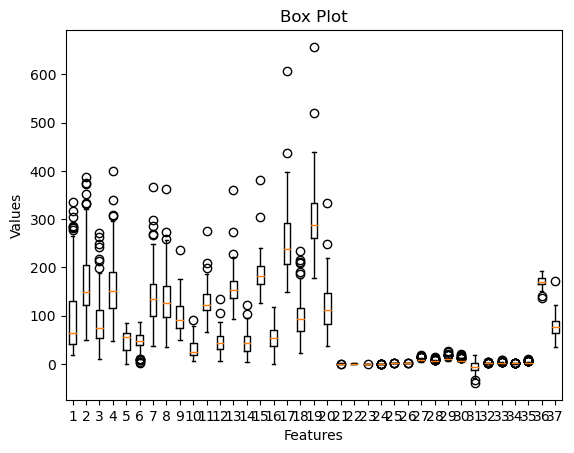

In [102]:
plt.boxplot(X)
plt.title('Box Plot')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

## Verifying Class Imbalance

In [16]:
# Verify the classes are balanced
print(f"Training set - Class 0: {sum(y_train == 0)}")
print(f"Training set - Class 1: {sum(y_train == 1)}")
print(f"Training set - Class 2: {sum(y_train == 2)}")
print(f"Training set - Class 3: {sum(y_train == 3)}")
print(f"Training set - Class 4: {sum(y_train == 4)}")

Training set - Class 0: 20
Training set - Class 1: 20
Training set - Class 2: 20
Training set - Class 3: 20
Training set - Class 4: 20


## Verifying Linear Relationship between Features and Target

### 1) Model Performance:

The code below is used to verify the linear separability of the training set. The first method consists in fitting a linear  (e.g., linear regression) and a nonlinear model (e.g., random forest) to the data in order to compare their performance. If the nonlinear model performs significantly better than the linear model, it suggests that the relationships between features and the target variable are highly nonlinear.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Linear model
linear_model = LinearRegression()
scores_linear = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_linear = -np.mean(scores_linear)

# Nonlinear model
nonlinear_model = RandomForestRegressor()
scores_nonlinear = cross_val_score(nonlinear_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_nonlinear = -np.mean(scores_nonlinear)

# improve readability with pandas DataFrame
results = pd.DataFrame({'Linear model average MSE': [mse_linear],
                        'Nonlinear model average MSE': [mse_nonlinear]})
results

,Linear model average MSE,Nonlinear model average MSE
0,46.486398,7.162153


### 2) Correlation Coefficients: 

Compute three correlation coefficients methods to measure the correlation between each feature and the target variable. Each of these methods measures the strength and direction of the relationship between two variables, with values ranging from -1 (strong negative linear relationship) to 1 (strong positive linear relationship). A value of 0 means there is no linear relationship. 



In [18]:
from scipy.stats import pearsonr, spearmanr, kendalltau


correlations = {
    "pearson": [],
    "spearman": [],
    "kendall": [],
}

# Code used for some test (train_test_split returns a numpy array)

# for i in range(X_train.shape[1]):
#     corr_pearson, _ = pearsonr(X_train[:, i], y_train)
#     corr_spearman, _ = spearmanr(X_train[:, i], y_train)
#     corr_kendall, _ = kendalltau(X_train[:, i], y_train)
    
#     correlations["pearson"].append(corr_pearson)
#     correlations["spearman"].append(corr_spearman)
#     correlations["kendall"].append(corr_kendall)

for col in X_train.columns:
    corr_pearson, _ = pearsonr(X_train[col], y_train)
    corr_spearman, _ = spearmanr(X_train[col], y_train)
    corr_kendall, _ = kendalltau(X_train[col], y_train)
    
    correlations["pearson"].append(corr_pearson)
    correlations["spearman"].append(corr_spearman)
    correlations["kendall"].append(corr_kendall)

# print means and standard deviations
print(f"Pearson correlation mean: {np.mean(correlations['pearson'])}")
print(f"Pearson correlation standard deviation: {np.std(correlations['pearson'])}", "\n")
print(f"Spearman correlation mean: {np.mean(correlations['spearman'])}")
print(f"Spearman correlation standard deviation: {np.std(correlations['spearman'])}", "\n")
print(f"Kendall correlation mean: {np.mean(correlations['kendall'])}")
print(f"Kendall correlation standard deviation: {np.std(correlations['kendall'])}")

Pearson correlation mean: 0.044052355154093316
Pearson correlation standard deviation: 0.18959454240732357 

Spearman correlation mean: 0.003696990416307507
Spearman correlation standard deviation: 0.1771835289143105 

Kendall correlation mean: 0.005245828059255228
Kendall correlation standard deviation: 0.11730027325219482


The results from the comparison between the performance of the linear and nonlinear models, as well as the correlation coefficients, suggest that the data is non-linearly separable. The mean squared error of the linear model is approximately 6 times the MSE of the non linear model (random forest). Furthermore, the correlation coefficients are all close to zero, which indicates that there is no linear relationship between the features and the target variable.

## Feature Importance:

Since PCA assumes that the principal components are linear combinations of the original features, if the features are not linearly separable, PCA will not be able to capture the most relevant information. Another approach is applied for feature selection and can be verified below.



In [90]:
kbest = SelectKBest(f_classif, k=21)
X_train_kbest = kbest.fit_transform(X_train, y_train)

selected_features_kbest = [feature for feature, mask in zip(feature_names, kbest.get_support()) if mask]
print("Selected features (SelectKBest):", selected_features_kbest)


Selected features (SelectKBest): ['LV_ES_volume', 'LV_ED_volume', 'RV_ES_volume', 'LV_ejection_fraction', 'RV_ejection_fraction', 'M_ES_volume', 'M_ED_volume', 'LV_ES_max_circumference', 'LV_ES_min_circumference', 'LV_ED_max_circumference', 'M_ES_max_circumference', 'M_mean_circularity_ES', 'M_mean_circularity_ED', 'M_mean_thickness_ES', 'M_mean_thickness_ED', 'M_max_thickness_ES', 'M_max_thickness_ED', 'ED_Ratio_RV_LV', 'ES_Ratio_RV_LV', 'ED_Ratio_M_LV', 'ES_Ratio_M_LV']


In [91]:
rf = RandomForestClassifier(n_estimators=1000)
selector = SelectFromModel(rf)
selector.fit(X_train, y_train)

X_train_rf_importance = selector.transform(X_train)

print("Number of selected features (Random Forest Importance):", X_train_rf_importance.shape[1] )

selected_features_rf_importance = [feature for feature, mask in zip(feature_names, selector.get_support()) if mask]
print("Selected features (Random Forest Importance):", selected_features_rf_importance)

Number of selected features (Random Forest Importance): 15
Selected features (Random Forest Importance): ['LV_ES_volume', 'LV_ED_volume', 'RV_ES_volume', 'LV_ejection_fraction', 'RV_ejection_fraction', 'LV_ES_max_circumference', 'M_mean_circularity_ES', 'M_mean_circularity_ED', 'M_mean_thickness_ES', 'M_max_thickness_ES', 'M_max_thickness_ED', 'ED_Ratio_RV_LV', 'ES_Ratio_RV_LV', 'ED_Ratio_M_LV', 'ES_Ratio_M_LV']


In [92]:
threshold = 0.85
corr_matrix = pd.DataFrame(X_train).corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > threshold)]

X_train_corr = pd.DataFrame(X_train).drop(to_drop, axis=1)

selected_features_corr = [feature for i, feature in enumerate(feature_names) if i not in to_drop]
print("Selected features (Correlation-based):", selected_features_corr)    

Selected features (Correlation-based): ['LV_ES_volume', 'RV_ES_volume', 'RV_ejection_fraction', 'M_ES_volume', 'LV_ES_max_circumference', 'LV_ES_min_circumference', 'LV_ED_min_circumference', 'RV_ES_max_circumference', 'RV_ES_min_circumference', 'RV_ED_min_circumference', 'M_ES_min_circumference', 'RV_mean_circularity_ES', 'RV_mean_circularity_ED', 'M_mean_circularity_ES', 'LV_mean_circularity_ES', 'LV_mean_circularity_ED', 'M_mean_thickness_ES', 'M_ejection_fraction', 'ED_Ratio_RV_LV', 'Height', 'Weight']


In [93]:
selector = SelectKBest(mutual_info_classif, k=21)
X_train_mutual_info = selector.fit_transform(X_train, y_train)

selected_features_mutual_info = [feature for feature, mask in zip(feature_names, selector.get_support()) if mask]
print("Selected features (Mutual Information):", selected_features_mutual_info)

Selected features (Mutual Information): ['LV_ES_volume', 'LV_ED_volume', 'RV_ES_volume', 'LV_ejection_fraction', 'RV_ejection_fraction', 'M_ES_volume', 'M_ED_volume', 'LV_ES_max_circumference', 'LV_ED_max_circumference', 'M_ES_max_circumference', 'M_ED_max_circumference', 'RV_mean_circularity_ED', 'M_mean_circularity_ES', 'M_mean_circularity_ED', 'M_mean_thickness_ES', 'M_max_thickness_ES', 'M_max_thickness_ED', 'ED_Ratio_RV_LV', 'ES_Ratio_RV_LV', 'ED_Ratio_M_LV', 'ES_Ratio_M_LV']


In [94]:
# Combine the selected features from all methods
combined_features = selected_features_kbest + selected_features_rf_importance + selected_features_corr + selected_features_mutual_info # + selected_features_sfs

# Count the occurrences of each feature
feature_counter = Counter(combined_features)

# Set the minimum number of votes required for a feature to be selected
min_votes = 3  # Adjust this value based on your preferences

# Get the features that meet the minimum vote threshold
best_features = [feature for feature, count in feature_counter.items() if count >= min_votes]

print("Best features:", best_features)
print("Number of best features:", len(best_features))

Best features: ['LV_ES_volume', 'LV_ED_volume', 'RV_ES_volume', 'LV_ejection_fraction', 'RV_ejection_fraction', 'M_ES_volume', 'LV_ES_max_circumference', 'M_mean_circularity_ES', 'M_mean_circularity_ED', 'M_mean_thickness_ES', 'M_max_thickness_ES', 'M_max_thickness_ED', 'ED_Ratio_RV_LV', 'ES_Ratio_RV_LV', 'ED_Ratio_M_LV', 'ES_Ratio_M_LV']
Number of best features: 16


In [ ]:
# Assuming your data is in pandas DataFrames
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Select only the best features for X_train and X_test
X_train = X_train[best_features]
X_test = X_test[best_features]

## Random Forest

In [70]:
# Creating a RandomForestClassifier object
rf = RandomForestClassifier()

# Defining the hyperparameter search space for GridSearchCV
param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 5, 7, 10]
}

# Creating a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fitting the GridSearchCV to the entire dataset
grid_search.fit(X_train, y_train)

# Printing the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Evaluate the best model using cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
print("Cross-validated scores:", cv_scores)
print("Average CV score:", np.mean(cv_scores))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters found by GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 500}
Cross-validated scores: [0.75 0.95 0.9  0.75 0.85]
Average CV score: 0.8400000000000001


In [71]:
grid_search.best_estimator_.fit(X_train, y_train)
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred

results = pd.DataFrame({'Id': patient_ID[100:150],
                        'Category': y_pred.astype(int)})

results.to_csv('results2002.csv', index=False)

## Stacking :

In [96]:
# Define the number of folds
n_splits = 5

# Create a KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define base classifier models and their parameter grids
base_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=5000, n_jobs=-1,random_state=42),
        'params': {
            'tol': [1e-4, 1e-3, 1e-2],
            'C': [0.1, 1.0, 10.0],
            'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        }
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(n_jobs=-1),
        'params': {
            'n_neighbors': [2, 3, 4, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'l2']
            
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(n_jobs=-1, random_state=42),
        'params': {
            'n_estimators': [1000, 2000],
            'max_depth': [None, 3, 5, 10],
            'min_samples_split': [2, 3, 4, 5, 6],
            'min_samples_leaf': [1, 2, 3, 5, 7, 10]
        }
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [10, 50, 100],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [1, 3, 5],
            'subsample': [0.5, 0.8, 1.0]
        }
    }
} # Keep the same dictionary as before
warnings.filterwarnings("ignore", category=FutureWarning)

# Perform GridSearchCV for each base classifier and store the best models
best_models = {}
for classifier_name, classifier_info in base_classifiers.items():
    grid_search = GridSearchCV(classifier_info['model'], classifier_info['params'], cv=kf, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    print(f"{classifier_name} - Best parameters: {grid_search.best_params_}")
    print(f"{classifier_name} - Best score: {grid_search.best_score_ * 100:.2f}%")
    best_models[classifier_name] = grid_search.best_estimator_

# Create a StackingClassifier using the best models
stacking_model = StackingClassifier(estimators=list(best_models.items()), final_estimator=best_models['RandomForest'])

# Apply k-fold cross-validation on the StackingClassifier
stacking_cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=kf, scoring='accuracy')
mean_stacking_cv_score = stacking_cv_scores.mean() * 100
std_stacking_cv_score = stacking_cv_scores.std() * 100
print(f"StackingClassifier - k-fold cross-validation mean score: {mean_stacking_cv_score:.2f}%")
print(f"StackingClassifier - k-fold cross-validation standard deviation: {std_stacking_cv_score:.2f}%")

LogisticRegression - Best parameters: {'C': 10.0, 'solver': 'saga', 'tol': 0.01}
LogisticRegression - Best score: 95.00%
KNeighbors - Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
KNeighbors - Best score: 93.00%
RandomForest - Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
RandomForest - Best score: 94.00%
SVM - Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
SVM - Best score: 92.00%
GradientBoosting - Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.5}
GradientBoosting - Best score: 94.00%
StackingClassifier - k-fold cross-validation mean score: 91.00%
StackingClassifier - k-fold cross-validation standard deviation: 5.83%


In [97]:
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
y_pred

results = pd.DataFrame({'Id': patient_ID[100:150],
                        'Category': y_pred.astype(int)})

results.to_csv('results2350.csv', index=False)

# Scratch Area

This part of the notebook contains only code snippets used for understanding the dataset and for testing (segmentation attempts, statistical frameworks etc.) and should not be considered for evaluation.

In [ ]:

# Scale the data using MinMaxScaler
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)



# n_components = 18  # Choose the number of components you want to keep
# pca = PCA(n_components=n_components)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# Create a StratifiedKFold object
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the Random Forest model and its parameter grid
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
param_grid = {
    'max_depth': [2, 3, 5, 7, 9],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

# # Create a custom scorer using the F2 score
# beta = 2
# f2_scorer = make_scorer(fbeta_score, beta=beta, average='macro')

# scoring_metrics = {
#     'accuracy': make_scorer(accuracy_score),
#     'f2_score': f2_scorer
# }

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Random Forest - Best parameters: {grid_search.best_params_}")
print(f"Random Forest - Best score: {grid_search.best_score_ * 100:.2f}%")

# Get the mean and standard deviation of cross-validation scores for the best hyperparameters
best_index = grid_search.best_index_
std_score = grid_search.cv_results_['std_test_score'][best_index]

print(f"Random Forest - Best standard deviation: {std_score * 100:.2f}%")

# Print the best parameters and score
# print(f"Random Forest - Best parameters: {grid_search.best_params_}")

# results = pd.DataFrame(grid_search.cv_results_)

# # Extract and print the mean test scores and standard deviation for each scoring metric
# for metric in scoring_metrics.keys():
#     mean_test_score = results[f'mean_test_{metric}'].max()
#     std_test_score = results.loc[results[f'mean_test_{metric}'].idxmax(), f'std_test_{metric}']
#     print(f"Random Forest - Best mean {metric}: {mean_test_score * 100:.2f}% (+/- {std_test_score * 100:.2f}%)")

Random Forest - Best parameters: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}
Random Forest - Best score: 91.00%
Random Forest - Best standard deviation: 6.63%


In [ ]:
X = features.drop(columns=['Category'])
y = features['Category']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33333, shuffle=False)

# Alternatively, scale the data using RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# n_components = 14  # Choose the number of components you want to keep
# pca = PCA(n_components=n_components)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

mean_score = 0
while mean_score < 0.95:
    model2 = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
    # model2.fit(X_train, y_train)

    # Perform cross-validation (5-fold in this example)
    cv_scores = cross_val_score(model2, X_train, y_train, cv=skf)

    # Calculate the mean and standard deviation of the cross-validation scores
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)

    # print(f"Mean cross-validation score: {mean_score:.2f}")
    # print(f"Standard deviation of cross-validation score: {std_score:.2f}")

In [ ]:
cv_scores = cross_val_score(model2, X_train, y_train, cv=5)

# Calculate the mean and standard deviation of the cross-validation scores
mean_score = np.mean(cv_scores)
std_score = np.std(cv_scores)

In [ ]:
print(f"Mean cross-validation score: {mean_score:.2f}")
print(f"Standard deviation of cross-validation score: {std_score:.2f}")

Mean cross-validation score: 0.96
Standard deviation of cross-validation score: 0.04


In [ ]:
save_model2 = model2

In [ ]:
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
y_pred

results = pd.DataFrame({'Id': patient_ID[100:150],
                        'Category': y_pred.astype(int)})

results.to_csv('results2058.csv', index=False)

In [ ]:
final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_pred

array([2., 4., 0., 3., 4., 1., 0., 0., 4., 4., 3., 3., 4., 0., 0., 4., 2.,
       3., 1., 0., 4., 0., 3., 3., 1., 2., 1., 4., 2., 4., 0., 4., 3., 2.,
       0., 0., 2., 3., 1., 4., 2., 1., 2., 1., 4., 2., 0., 0., 1., 1.])

In [ ]:
results = pd.DataFrame({'Id': patient_ID[100:150],
                        'Category': y_pred.astype(int)})

results.to_csv('results.csv', index=False)

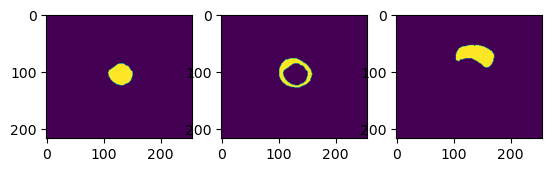

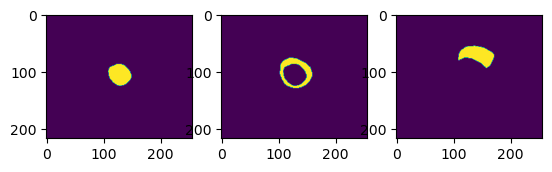

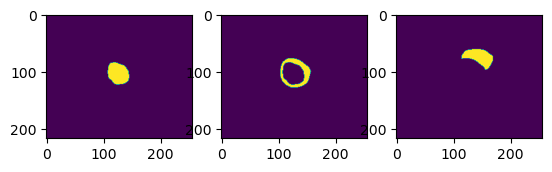

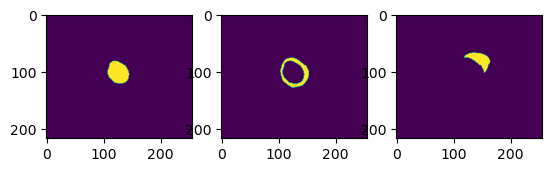

In [ ]:
for i in range(4):
    plt.subplot(1,3,1)
    plt.imshow(img_LV_ED[35][i,:,:])
    plt.subplot(1,3,2)
    plt.imshow(img_M_ED[35][i,:,:])
    plt.subplot(1,3,3)
    plt.imshow(img_RV_ED[35][i,:,:])
    plt.show()

In [ ]:
model = grid_search.best_estimator_ 

num_random_states = 10
n_splits = 5

mean_scores = []

for random_state in range(num_random_states):
    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Calculate the cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

    # Calculate and store the mean accuracy score
    mean_scores.append(cv_scores.mean())

# Calculate the mean and standard deviation of the mean accuracy scores
mean_of_means = np.mean(mean_scores)
std_of_means = np.std(mean_scores)

print(f"Mean accuracy across random states: {mean_of_means * 100:.2f}%")
print(f"Standard deviation of accuracy across random states: {std_of_means * 100:.2f}%")

Mean accuracy across random states: 87.60%
Standard deviation of accuracy across random states: 1.28%


In [ ]:
# Calculate and print the score for each tree in the random forest

best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

scores = []
for i, tree in enumerate(best_rf_model.estimators_):
    tree_score = tree.score(X_train, y_train)
    print(f"Tree {i + 1} score: {tree_score:.2f}")
    scores.append(tree_score)
mean_score = sum(scores) / len(scores)
print(f"Mean accuracy score of all trees: {mean_score:.2f}")

Tree 1 score: 0.78
Tree 2 score: 0.86
Tree 3 score: 0.76
Tree 4 score: 0.73
Tree 5 score: 0.75
Tree 6 score: 0.86
Tree 7 score: 0.78
Tree 8 score: 0.80
Tree 9 score: 0.75
Tree 10 score: 0.75
Tree 11 score: 0.80
Tree 12 score: 0.76
Tree 13 score: 0.78
Tree 14 score: 0.83
Tree 15 score: 0.86
Tree 16 score: 0.74
Tree 17 score: 0.86
Tree 18 score: 0.76
Tree 19 score: 0.73
Tree 20 score: 0.66
Tree 21 score: 0.75
Tree 22 score: 0.78
Tree 23 score: 0.74
Tree 24 score: 0.81
Tree 25 score: 0.81
Tree 26 score: 0.77
Tree 27 score: 0.77
Tree 28 score: 0.87
Tree 29 score: 0.74
Tree 30 score: 0.78
Tree 31 score: 0.73
Tree 32 score: 0.76
Tree 33 score: 0.80
Tree 34 score: 0.73
Tree 35 score: 0.80
Tree 36 score: 0.69
Tree 37 score: 0.83
Tree 38 score: 0.85
Tree 39 score: 0.80
Tree 40 score: 0.74
Tree 41 score: 0.76
Tree 42 score: 0.72
Tree 43 score: 0.83
Tree 44 score: 0.78
Tree 45 score: 0.76
Tree 46 score: 0.85
Tree 47 score: 0.80
Tree 48 score: 0.81
Tree 49 score: 0.84
Tree 50 score: 0.75
Tree 51 s

In [ ]:
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Print the depth of each tree in the Random Forest model
for idx, tree in enumerate(best_rf_model.estimators_):
    tree_depth = tree.tree_.max_depth
    print(f"Tree {idx + 1} depth: {tree_depth}")
    
# Calculate the average depth of the trees in the Random Forest model
average_depth = np.mean([tree.tree_.max_depth for tree in best_rf_model.estimators_])
print(f"Average tree depth: {average_depth:.2f}")

Tree 1 depth: 6
Tree 2 depth: 7
Tree 3 depth: 7
Tree 4 depth: 7
Tree 5 depth: 7
Tree 6 depth: 6
Tree 7 depth: 6
Tree 8 depth: 7
Tree 9 depth: 7
Tree 10 depth: 7
Tree 11 depth: 7
Tree 12 depth: 7
Tree 13 depth: 7
Tree 14 depth: 7
Tree 15 depth: 7
Tree 16 depth: 6
Tree 17 depth: 7
Tree 18 depth: 7
Tree 19 depth: 7
Tree 20 depth: 6
Tree 21 depth: 7
Tree 22 depth: 7
Tree 23 depth: 7
Tree 24 depth: 7
Tree 25 depth: 7
Tree 26 depth: 7
Tree 27 depth: 7
Tree 28 depth: 7
Tree 29 depth: 7
Tree 30 depth: 6
Tree 31 depth: 7
Tree 32 depth: 7
Tree 33 depth: 6
Tree 34 depth: 7
Tree 35 depth: 7
Tree 36 depth: 7
Tree 37 depth: 7
Tree 38 depth: 7
Tree 39 depth: 7
Tree 40 depth: 6
Tree 41 depth: 7
Tree 42 depth: 6
Tree 43 depth: 6
Tree 44 depth: 6
Tree 45 depth: 7
Tree 46 depth: 7
Tree 47 depth: 7
Tree 48 depth: 7
Tree 49 depth: 7
Tree 50 depth: 7
Tree 51 depth: 7
Tree 52 depth: 7
Tree 53 depth: 7
Tree 54 depth: 7
Tree 55 depth: 7
Tree 56 depth: 6
Tree 57 depth: 7
Tree 58 depth: 7
Tree 59 depth: 7
Tree 6

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA


# Separate the features and target variable
X = features.drop(columns=['Category'])
y = features['Category']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33333, shuffle=False)

# Scale the data using MinMaxScaler
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Alternatively, scale the data using RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# n_components = 20  # Choose the number of components you want to keep
# pca = PCA(n_components=n_components)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# Define the number of folds
n_splits = 2

# Create a KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define base classifier models and their parameter grids
base_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=5000, random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [1000],
            'max_depth': [None, 3, 5, 10],
            'min_samples_split': [2, 3, 4]
        }
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [45, 50, 55],
            'learning_rate': [0.01, 0.4, 0.6],
            'max_depth': [1, 3, 5],
            'subsample': [0.5, 0.8, 1.0]
        }
    }
}
import warnings
warnings.filterwarnings("ignore",  category=FutureWarning)

# Perform GridSearchCV for each base classifier and store the best models
best_models = {}
for classifier_name, classifier_info in base_classifiers.items():
    grid_search = GridSearchCV(classifier_info['model'], classifier_info['params'], cv=kf, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    print(f"{classifier_name} - Best parameters: {grid_search.best_params_}")
    print(f"{classifier_name} - Best score: {grid_search.best_score_ * 100:.2f}%")
    best_models[classifier_name] = grid_search.best_estimator_

# Create a StackingClassifier using the best models
stacking_model = StackingClassifier(estimators=list(best_models.items()), final_estimator=LogisticRegression(max_iter=1000))

# Apply k-fold cross-validation on the StackingClassifier
stacking_cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=kf, scoring='accuracy')
mean_stacking_cv_score = stacking_cv_scores.mean() * 100
std_stacking_cv_score = stacking_cv_scores.std() * 100
print(f"StackingClassifier - k-fold cross-validation mean score: {mean_stacking_cv_score:.2f}%")
print(f"StackingClassifier - k-fold cross-validation standard deviation: {std_stacking_cv_score:.2f}%")

# Train the StackingClassifier on the entire training set using the best models
stacking_model.fit(X_train, y_train)

# Evaluate the StackingClassifier on the test set
# stacking_test_score = stacking_model.score(X_test, y_test) * 100
# print(f"StackingClassifier - Test set score: {stacking_test_score:.2f}%")

stacking_model.predict(X_test)


In [ ]:
# Separate the features and target variable
X = features.drop(columns=['Category'])
y = features['Category']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33333, shuffle=False)

# Alternatively, scale the data using RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n_components = 20  # Choose the number of components you want to keep
pca = PCA(n_components=n_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

stacking_model.fit(X_train, y_train)
stacking_model.predict(X_test)

array([2., 4., 0., 3., 4., 1., 0., 0., 4., 4., 3., 3., 0., 0., 0., 4., 2.,
       3., 1., 0., 4., 0., 3., 3., 1., 2., 1., 4., 2., 4., 1., 4., 3., 2.,
       0., 3., 1., 3., 2., 4., 2., 1., 2., 1., 4., 2., 3., 2., 1., 1.])

In [ ]:
y_pred = stacking_model.predict(X_test)
print(y_pred)

results = pd.DataFrame({'Id': patient_ID[100:150],
                        'Category': y_pred.astype(int)})

results.to_csv('results_stacking.csv', index=False)



[2. 4. 0. 3. 4. 1. 0. 0. 4. 4. 3. 3. 4. 0. 0. 4. 2. 3. 1. 0. 4. 0. 3. 3.
 1. 2. 1. 4. 2. 4. 2. 4. 3. 2. 0. 3. 1. 3. 2. 4. 2. 2. 2. 1. 4. 2. 3. 2.
 1. 1.]


In [ ]:
# take the category from the csv file
category = pd.read_csv(os.getcwd() + '/results_stacking (1).csv')
category = category['Category']
print(category.to_numpy())

[2 4 0 3 4 1 0 0 4 4 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 0 3 1
 3 2 4 2 1 2 1 4 2 3 2 1 1]


In [ ]:
# take the category from the csv file
category = pd.read_csv(os.getcwd() + '/results_possible_best2 (1).csv')
category = category['Category']
category = category.to_numpy().astype("float64")
print(category)

# compare with y_pred 
print(np.sum(category == y_pred) )

[2. 4. 0. 3. 4. 1. 0. 0. 4. 4. 3. 3. 0. 0. 0. 4. 2. 3. 1. 0. 4. 3. 3. 3.
 1. 2. 2. 4. 2. 4. 1. 4. 3. 2. 0. 3. 1. 3. 2. 0. 2. 1. 2. 2. 4. 2. 0. 1.
 1. 1.]
41


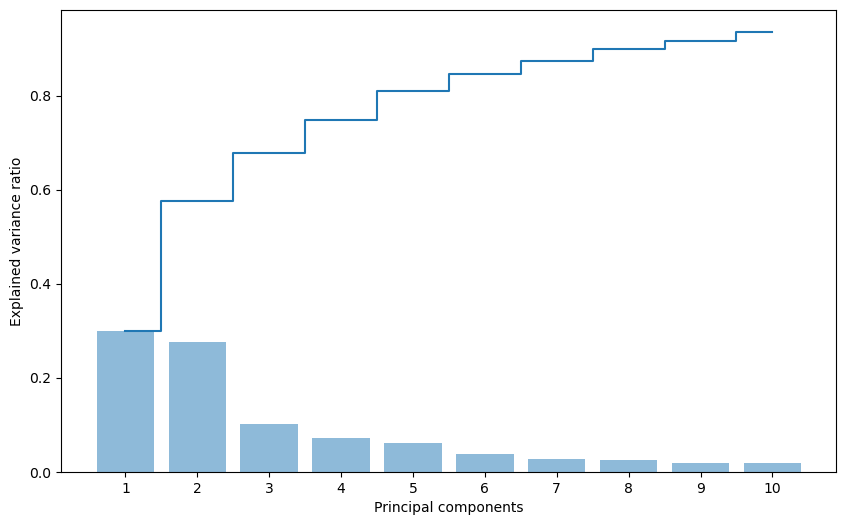

In [ ]:
# plot the variance explained by each principal component
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(range(1, n_components + 1))
plt.show()
    

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, category, test_size=1/3, train_size=2/3, shuffle=False)

X_train = X_train.drop(['Category'], axis=1)
X_test = X_test.drop(['Category'], axis=1)


In [ ]:
scaler = MinMaxScaler().fit(X_train)
# scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## TENTATIVA PCA


In [ ]:
# Apply PCA to discover the most important features (preserve the names of the features)
pca = decomposition.PCA(n_components=10)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(np.nan_to_num(X_test))

# Get the principal components as a dataframe with named columns
components = pd.DataFrame(X_train, columns=['PC1', 'PC2', 'PC3', 'PC4',
                                            'PC5', 'PC6', 'PC7', 'PC8',
                                            'PC9', 'PC10'])

# Add the original feature names as column names
components.columns = feature_names[:10]

# Print the first few rows of the dataframe
print(components.head())


In [ ]:
# apply PCA 
pca = decomposition.PCA(n_components=10)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(np.nan_to_num(X_test))

# show the most important features


explained_variance = pca.explained_variance_ratio_

# Create a pandas dataframe to display the explained variance for each feature
df = pd.DataFrame({'feature': range(1, pca.n_components_+1), 'explained_variance': explained_variance})
print(df)

# Get the most important features (i.e., those with the highest explained variance)
most_important = pca.components_[0]
print('Most important features:', most_important)

   feature  explained_variance
0        1            0.337141
1        2            0.211306
2        3            0.147621
3        4            0.084009
4        5            0.058333
5        6            0.053164
6        7            0.033668
7        8            0.030693
8        9            0.024188
9       10            0.019878
Most important features: [ 1.  0. -0. -0. -0. -0. -0. -0. -0. -0.]


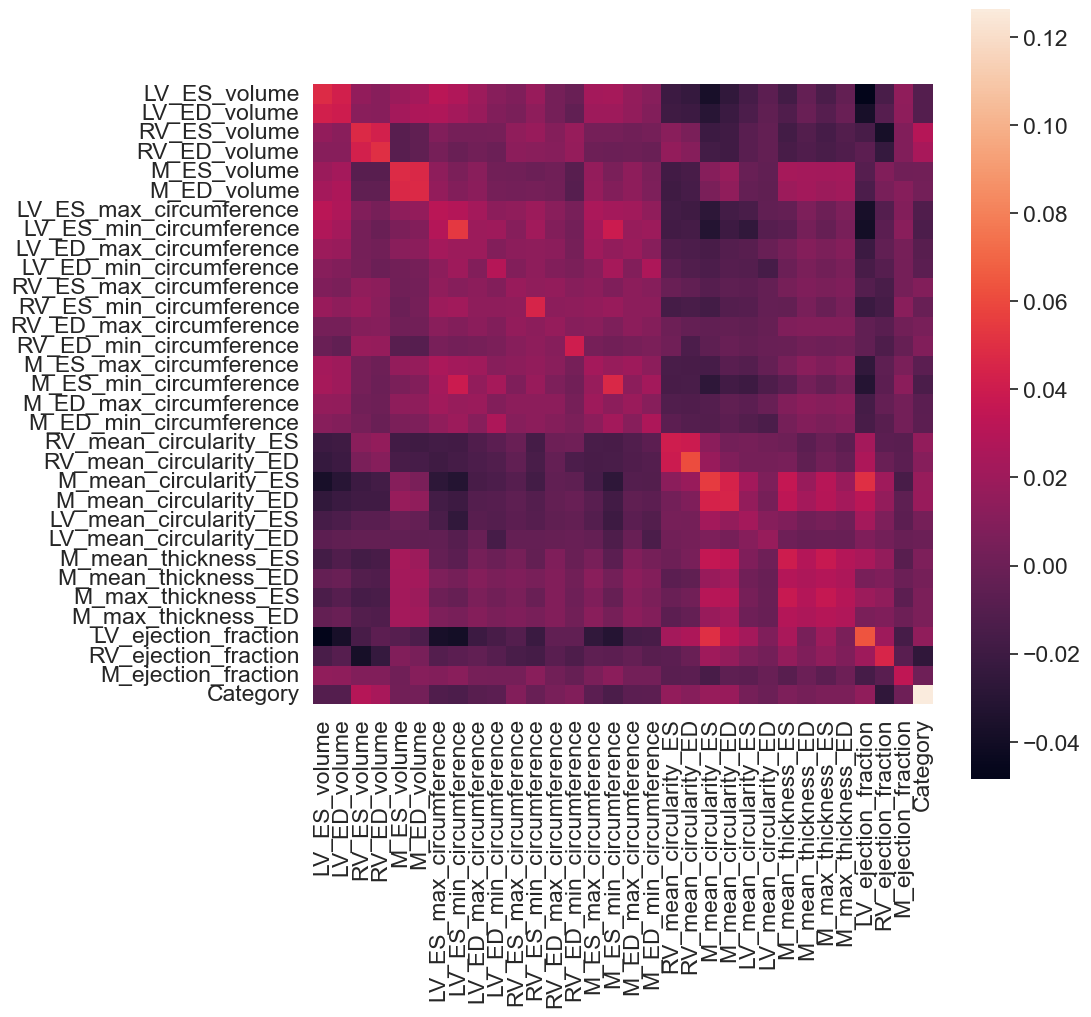

In [ ]:
# plot covariance matrix
cov_mat = np.cov(X_train.T)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                    cbar=True,
                    # annot=True,
                    square=True,
                    fmt='.2f',
                    annot_kws={'size': 15},
                    yticklabels=features.columns,
                    xticklabels=features.columns)
plt.show()

## RF


In [ ]:
clf = RandomForestClassifier()


In [ ]:
# Create a random forest classifier

# try a grid search
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90],
#     'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'min_samples_leaf': [1, 2, 3, 4, 5],
#     'min_samples_split': [2, 3, 4, 5, 6],
#     'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900]
# }

param_grid = {'n_estimators': np.arange(10, 50, 10), 
               'min_samples_leaf': np.arange(2,10), 
               'min_samples_split': np.arange(2,10), 
               'max_depth': np.arange(2,8)}   


grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                            scoring = 'accuracy', cv = 5)

grid_search.fit(X_train, y_train)

grid_search.best_params_
    

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 10}

In [ ]:
best_params=grid_search.best_params_
clf = RandomForestClassifier(min_samples_leaf=best_params['min_samples_leaf'],
                            n_estimators=best_params['n_estimators'],
                            min_samples_split=best_params['min_samples_split'],
                            max_depth=best_params['max_depth'])
clf.fit(X_train,y_train)


y_pred_train = clf.predict(X_train) 
print(y_pred_train)
# Score in the training set
print('Score in the training set is {0}'.format(clf.score(X_train,y_train)) )

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
print(f'Features in order of importance: {list(features.columns[indices])}')

# while clf.score(X_train,y_train) > 0.87:
#     # best_params=grid_search.best_params_
#     clf = RandomForestClassifier(min_samples_leaf=9,
#                                 n_estimators=30,
#                                 min_samples_split=8,
#                                 max_depth=2)
#     clf.fit(X_train,y_train)
    

#     y_pred_train = clf.predict(X_train) 
#     # print(y_pred_train)
#     # # Score in the training set
#     # print('Score in the training set is {0}'.format(clf.score(X_train,y_train)) )

#     importances = clf.feature_importances_
#     indices = np.argsort(importances)[::-1]
#     # print(f'Features in order of importance: {list(features.columns[indices])}')

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 3. 0. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 3. 3. 0. 4. 4. 4. 4. 4. 4. 4. 0. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4.]
Score in the training set is 0.93
Features in order of importance: ['LV_ES_volume', 'LV_ejection_fraction', 'LV_ED_volume', 'M_mean_thickness_ES', 'RV_ES_volume', 'M_ED_volume', 'RV_ejection_fraction', 'LV_ED_max_circumference', 'M_ES_volume', 'RV_mean_circularity_ES', 'M_mean_thickness_ED', 'RV_ED_volume', 'RV_mean_circularity_ED', 'M_ED_max_circumference', 'RV_ED_max_circumference', 'Weight', 'LV_ES_min_circumference', 'Height', 'M_ES_min_circumference', 'LV_mean_circularity_ES', 'LV_mean_circularity_ED', 'RV_ES_min_circumference']


## TESTE

In [ ]:
# cross validation

from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=5)
print(f'Cross validation scores: {scores}')
print(f'Average cross validation score: {np.mean(scores)}')

# Score in the test set 


Cross validation scores: [1.   1.   0.95 0.95 1.  ]
Average cross validation score: 0.9800000000000001


## END TESTE

In [ ]:
# replace NaNs with 0s in the test set
# X_test = np.nan_to_num(X_test)
y_pred = clf.predict(X_test)
# print(y_pred)

df_test = pd.DataFrame({'Patient': patient_ID[100:150]})
df_test['Category'] = y_pred
# df_test

In [ ]:
y_pred.astype(int)

array([2, 4, 0, 3, 4, 1, 0, 0, 4, 4, 3, 3, 4, 0, 0, 4, 2, 3, 1, 0, 4, 4,
       3, 3, 1, 2, 2, 4, 2, 4, 1, 4, 3, 2, 0, 0, 1, 3, 2, 0, 2, 2, 2, 2,
       4, 2, 3, 1, 1, 1])

In [ ]:
results = pd.DataFrame({'Id': patient_ID[100:150],
                        'Category': y_pred.astype(int)})
results

In [ ]:
results.to_csv('results_possible_best2.csv', index=False)

In [ ]:
RV_perimeter_ES = compute_perimeter(img_RV_ES)
RV_perimeter_ED = compute_perimeter(img_RV_ED)


48.62741699796952


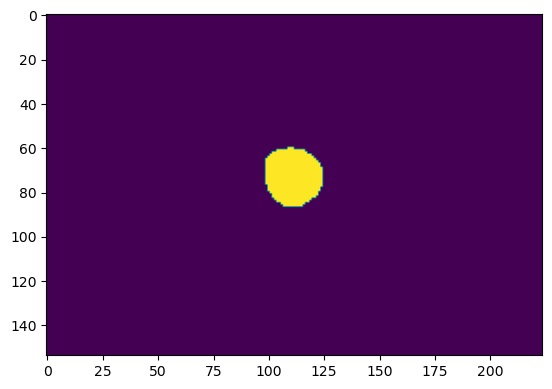

In [ ]:
img_measure = measure.perimeter(img_LV_ES[40][4,:,:])
print(img_measure)

plt.imshow(img_LV_ES[40][2,:,:])
plt.show()

In [ ]:
print('RV_ES_perimeter', compute_perimeter(img_LV_ES))
print('RV_ED_perimeter', compute_perimeter(img_LV_ED))

RV_ES_perimeter [115.5718133  110.87737367 113.08569978 124.09402589 122.4413347
 108.93595231 103.07737367 110.61879503 126.39108217 117.07148622
 118.64942272 116.90323064 105.82173875 142.36336931 112.50788232
 142.20184694 136.46612144 114.33110563 120.88397539  97.5403679
  54.94696065  41.1827458   44.92748915  41.0052257   66.95556353
  79.26955262  59.38782464  50.99681506  47.01130047  35.14213562
  60.54968044  45.53358068  54.35780248  40.26576878  51.08553989
  66.17335854  35.69442037 128.56118318  48.42031022  62.0884343
  64.51997351  81.72815451  67.00669188  69.03181814 101.36477008
  86.38365395  99.95978528  83.00927573 105.42353288 123.28986284
  79.55522682  90.74227086 110.62351054 113.13402384  85.54868521
  99.65648443 182.46311059  95.04840462  78.74721816  94.88135816
  71.28601315  71.52826675  52.35821305  62.74450854  48.93343637
  66.21257211  64.75567577  56.39865316  42.32758535  52.66785711
  66.86269837  60.65366931  52.1844877   62.51282464  54.569985

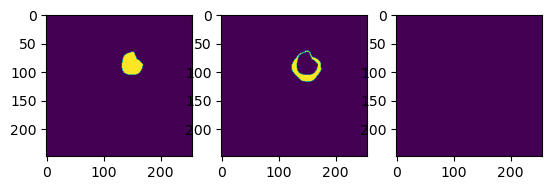

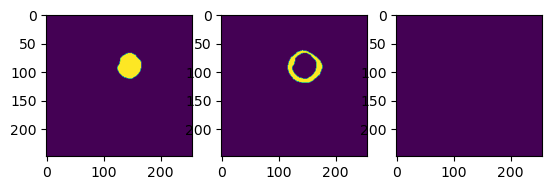

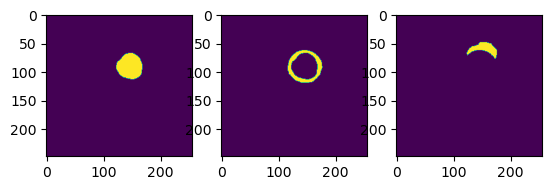

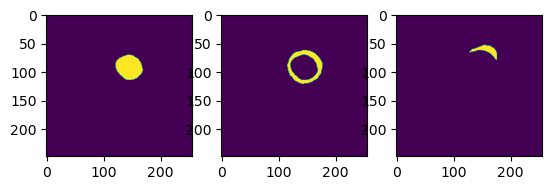

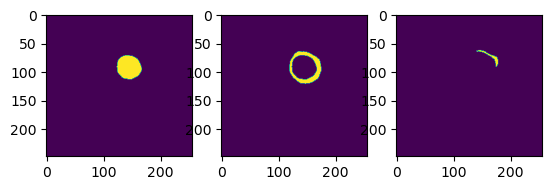

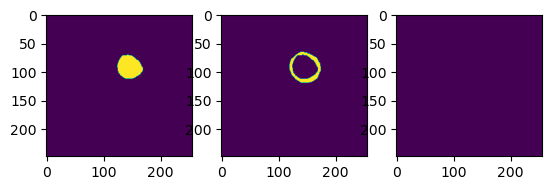

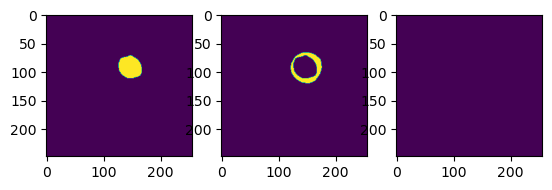

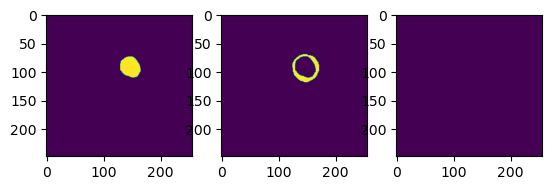

In [ ]:
for i in range(8):
    plt.subplot(1,3,1)
    plt.imshow(img_LV_ES[49][i,:,:])
    plt.subplot(1,3,2)
    plt.imshow(img_M_ES[49][i,:,:])
    plt.subplot(1,3,3)
    plt.imshow(img_RV_ES[49][i,:,:])
    plt.show()


In [ ]:
# img_test_thickness = mean_thickness(img_M_ES)
# img_max_thickness = max_thickness(img_M_ES)
# # img_min_thickness = min_thickness(img_M_ES)
# # img_std_thickness = std_thickness(img_M_ES)

# print(img_test_thickness)
# print(img_max_thickness)
# print(img_min_thickness)

In [ ]:
# plt.imshow(img_M_ES[0][5,:,:])


img_area_teste = compute_area(img_RV_ES)
img_perimeter_teste = compute_perimeter(img_RV_ES)
img_perimeter_teste2 = compute_perimeter(img_M_ES)

print(img_area_teste, 
        img_perimeter_teste,
            img_perimeter_teste2)

[ 406.5         192.75        893.875       565.375       538.57142857
  747.          760.875       583.16666667  414.375      1016.25
  745.75        264.5         585.25       1212.25        399.5
 1044.875      1196.11111111 1075.14285714  510.9         656.625
  390.          563.66666667  315.4         279.33333333  537.6
  470.16666667  537.75        388.85714286  402.85714286  164.66666667
  348.71428571  328.33333333  254.33333333  205.5         342.5
  426.          273.75       1509.66666667  318.16666667  363.75
  299.          386.33333333  257.          259.71428571  495.57142857
  469.71428571  359.33333333  210.4         231.33333333  436.66666667
  497.4         710.5         481.71428571  258.2         509.71428571
  606.71428571 2762.          327.6         416.33333333  405.25
  683.          650.          494.25        596.25        397.4
  713.71428571  734.42857143  471.8         194.5         302.
  515.66666667  576.          601.6         543.          341.692

In [ ]:
from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.io import output_notebook
output_notebook()

def affiche_pour_colab(im,MINI=None, MAXI=None,titre=''): #special colab, don't look
  def normalise_image_pour_bokeh(X,MINI,MAXI):
    if MAXI==None:
      MAXI = np.max(X)
    if MINI==None:
      MINI = np.min(X)
    imt=np.copy(X.copy())
    imt=(np.clip(imt,MINI,MAXI)/(MAXI-MINI))
    imt[imt<0]=0
    imt[imt>1]=1
    imt*=255
    sortie=np.empty((*imt.shape,4),dtype=np.uint8)
    for k in range(3):
      sortie[:,:,k]=imt
    sortie[:,:,3]=255
    return sortie

  img = im
  img=normalise_image_pour_bokeh(np.flipud(im),MINI,MAXI)
  p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], y_range=[im.shape[0], 0], x_range=[0, im.shape[1]])
  # p.x_range.range_padding = p.y_range.range_padding = 0
  # must give a vector of images
  p.image(image=[np.flipud(im)], x=0, y=im.shape[0], dw=im.shape[1], dh=im.shape[0], palette="Greys9", level="image")
  p.xgrid.visible = False
  p.ygrid.visible = False
  showbokeh(p)

def affiche(im,MINI=0.0, MAXI=None,titre='',printname=False):
  affiche_pour_colab(im,MINI=MINI, MAXI=MAXI,titre=titre) # under google colab many options disappear

Loading BokehJS ...

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [ ]:
for i in range(8):
    plt. figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(img_ES_seg[40].get_fdata()[:,:,i], cmap='gray')
    contours = measure.find_contours(img_ES_seg[40].get_fdata()[:,:,i], 0.5)
    # print(img_ES_seg[40].get_fdata()[90:150,100:160,i])
    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.subplot(1,2,2)
    plt.imshow(img_ES[40].get_fdata()[:,:,i], cmap='gray')
    plt.show()


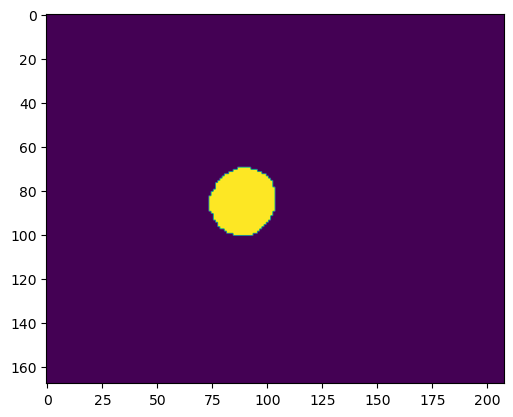

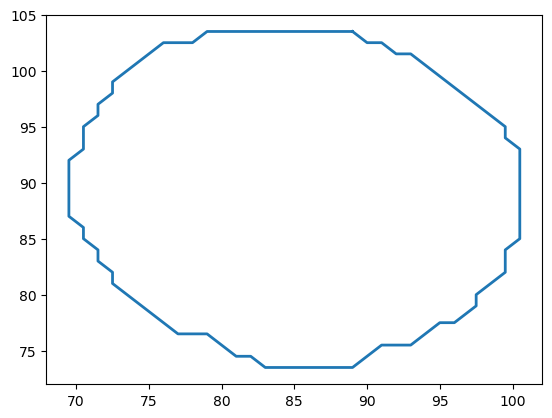

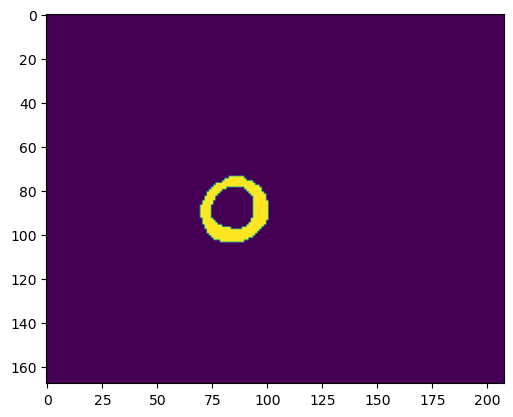

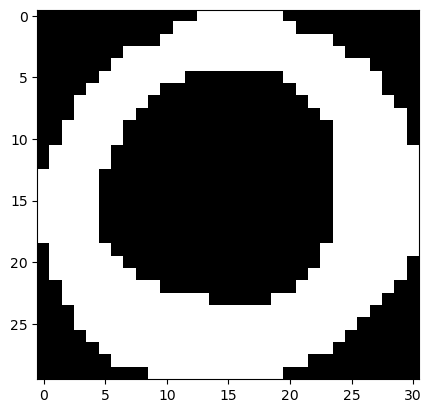

In [ ]:
props = measure.regionprops(measure.label(img_M_ES[4][4,:,:]), intensity_image=img_M_ES[4][4,:,:])[0]
contour = measure.find_contours(img_M_ES[4][4,:,:], 0.5)

x, y = np.meshgrid(np.arange(img_M_ES[4][4,:,:].shape[1]),
                   np.arange(img_M_ES[4][4,:,:].shape[0]))
x_flat = x.flatten()
y_flat = y.flatten()

coords = np.hstack((x_flat.reshape(-1, 1), y_flat.reshape(-1, 1)))

mask = measure.points_in_poly(coords, contour[0])
mask = mask.reshape(img_M_ES[4][4,:,:].shape).astype(int)

plt.imshow(mask)
plt.show()

# plt.plot(vertices[:, 1], vertices[:, 0], '--r', linewidth=2)
plt.plot(contour[0][:, 1], contour[0][:, 0], linewidth=2)
plt.show()

plt.imshow(img_M_ES[4][4,:,:])
plt.show()
plt.imshow(props.intensity_image, cmap='gray')
plt.show()

In [ ]:
volume_LV_ES = compute_volume(img_LV_ES, img_ES)

In [ ]:
print(volume_LV_ES/1000)

[194.309  33.127  41.748  19.925  50.81  131.762  52.31   41.987  33.878
  51.787  22.037  28.049  50.487  66.343  32.431  79.792 235.931  25.889
  91.144  23.144  57.333  77.684  27.05   41.496 121.872 210.251 172.477
  75.634 258.086  39.421 117.666  64.302  27.448 317.48   29.776  53.002
 123.853  62.973 228.041  42.259 280.661 156.007 191.238 156.585  64.585
 262.768  29.591 121.76  101.509 110.323]


In [ ]:
img_LV_ES[0].shape

(10, 256, 216)

In [ ]:
n_pixels_LV_ES = n_pixels(img_LV_ES)
print(n_pixels_LV_ES)

[ 7219  2340  1710  1066  3589  5397  3695  2010  2248  3658  1179  1273
  2701  3011  1640  5849 12622  1175  4609   948  2064  4156  1108  2220
  6520 10632  5582  3098  9115  2109  6295  4542  1388 13004  1593  2171
  6263  3369  5978  2985 15015  5796 10231  5441  4562 10763  1343  6514
  4607  5007]


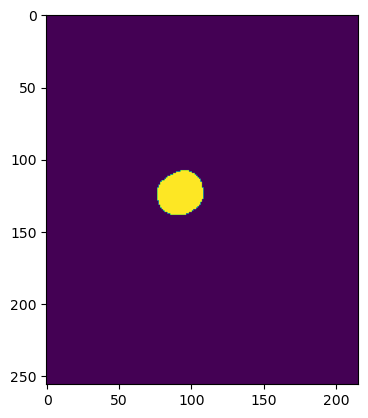

In [ ]:
plt.imshow(img_LV_ES[49][5,:,:])
plt.show()

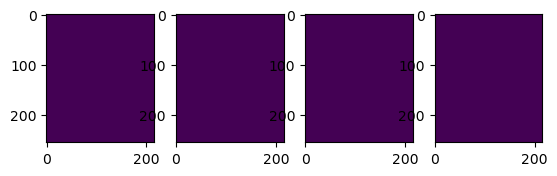

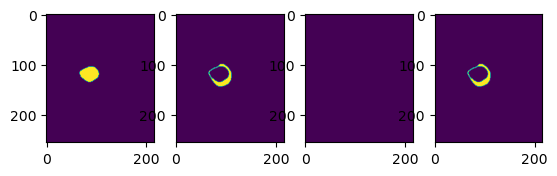

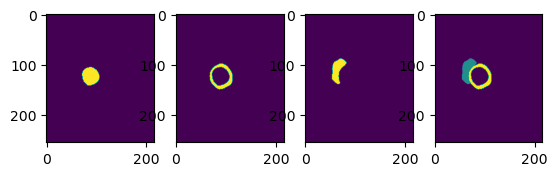

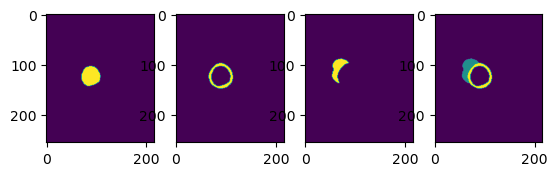

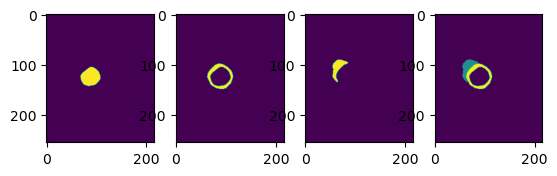

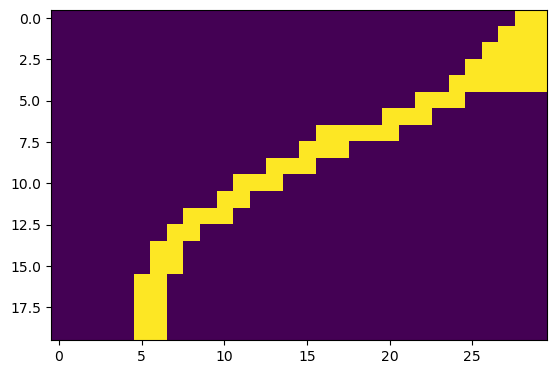

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 

In [ ]:
# plot some images to compare the segmentation
for i in range(5):
    plt.subplot(1,4,1)
    plt.imshow(img_LV_ES[0][i])
    plt.subplot(1,4,2)
    plt.imshow(img_M_ES[0][i])
    plt.subplot(1,4,3)
    plt.imshow(img_RV_ES[0][i])
    plt.subplot(1,4,4)
    plt.imshow(img_ES_seg[0].get_fdata()[:,:,i])
    plt.show()

plt.imshow(img_M_ES[0][1][100:120, 60:90])
plt.show()
print(img_M_ES[0][1][100:120, 60:90])

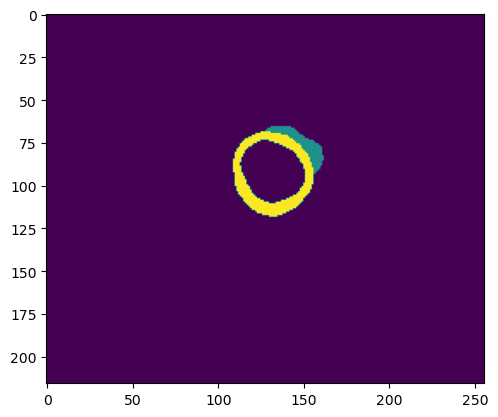

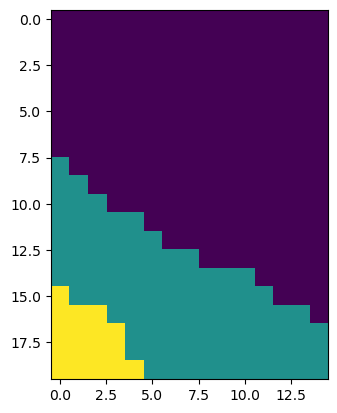

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [ ]:
plt.imshow(img_ED_seg[5].get_fdata()[:,:,5])
plt.show()

plt.imshow(img_ED_seg[5].get_fdata()[60:80,145:160,5])
plt.show()

print(img_ED_seg[5].get_fdata()[60:80,145:160,5])

In [ ]:
# transform img_LV_seg in an array of dimensions 50 x 256 x 216 x n 
img_LV_seg = np.array(img_LV_seg, dtype= object)

# patient id / img id / x / y 
print(img_LV_seg[1].shape)

plt.imshow(img_LV_seg[5][5])
plt.show()


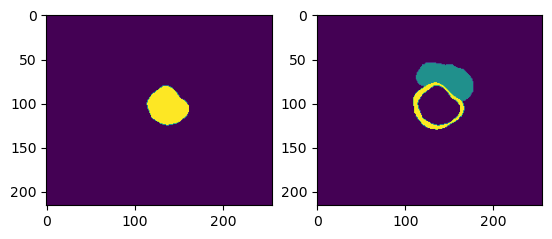

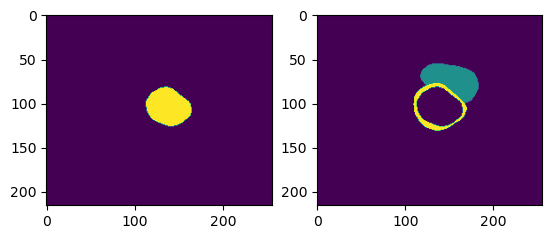

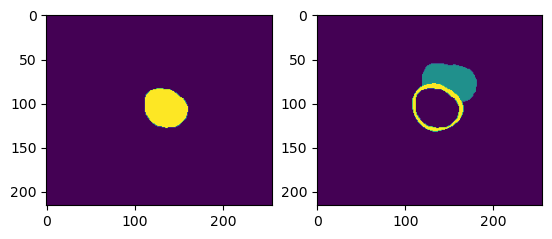

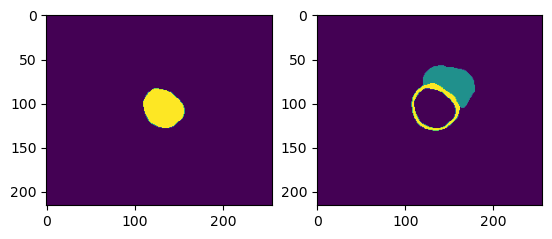

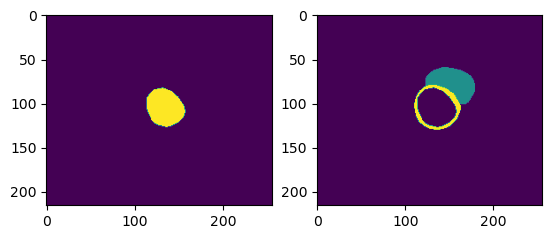

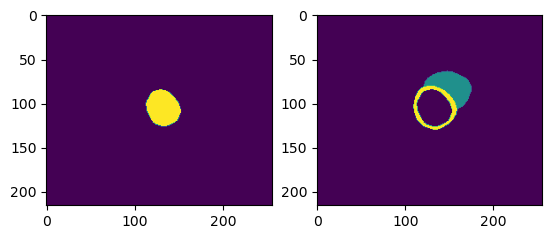

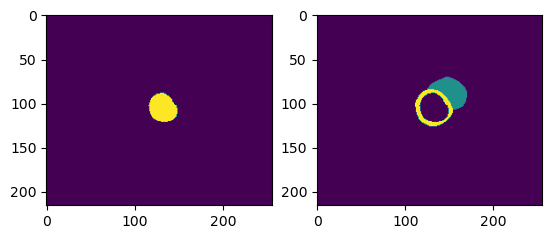

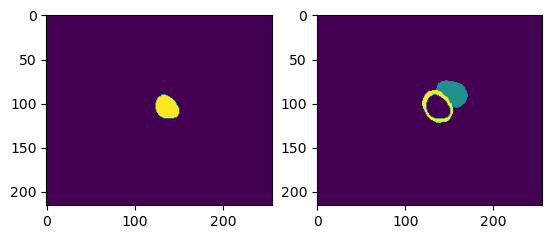

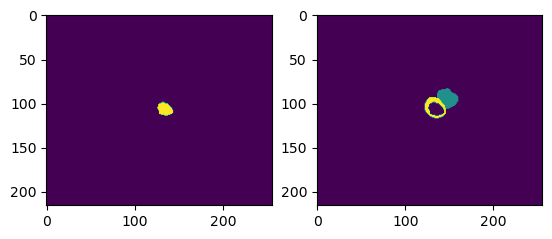

In [ ]:
# plot img_LV_seg and img_ED_seg side by side 
for i in range(9):
    plt.subplot(1,2,1)
    plt.imshow(img_LV_seg[45][i])
    plt.subplot(1,2,2)
    plt.imshow(img_ES_seg[45].get_fdata()[:,:,i])
    plt.show()


In [ ]:
img_ED[0].header['pixdim'][1:4]
print(img_ED[49].header)


<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 216   9   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [ 1.       1.48438  1.48438 10.       0.       0.       0.       0.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : -0.0
qoffset_y       : -0.0
qoffset_z       : 0.0
srow

In [ ]:
img_ED_seg[40].shape

(256, 216, 10)

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

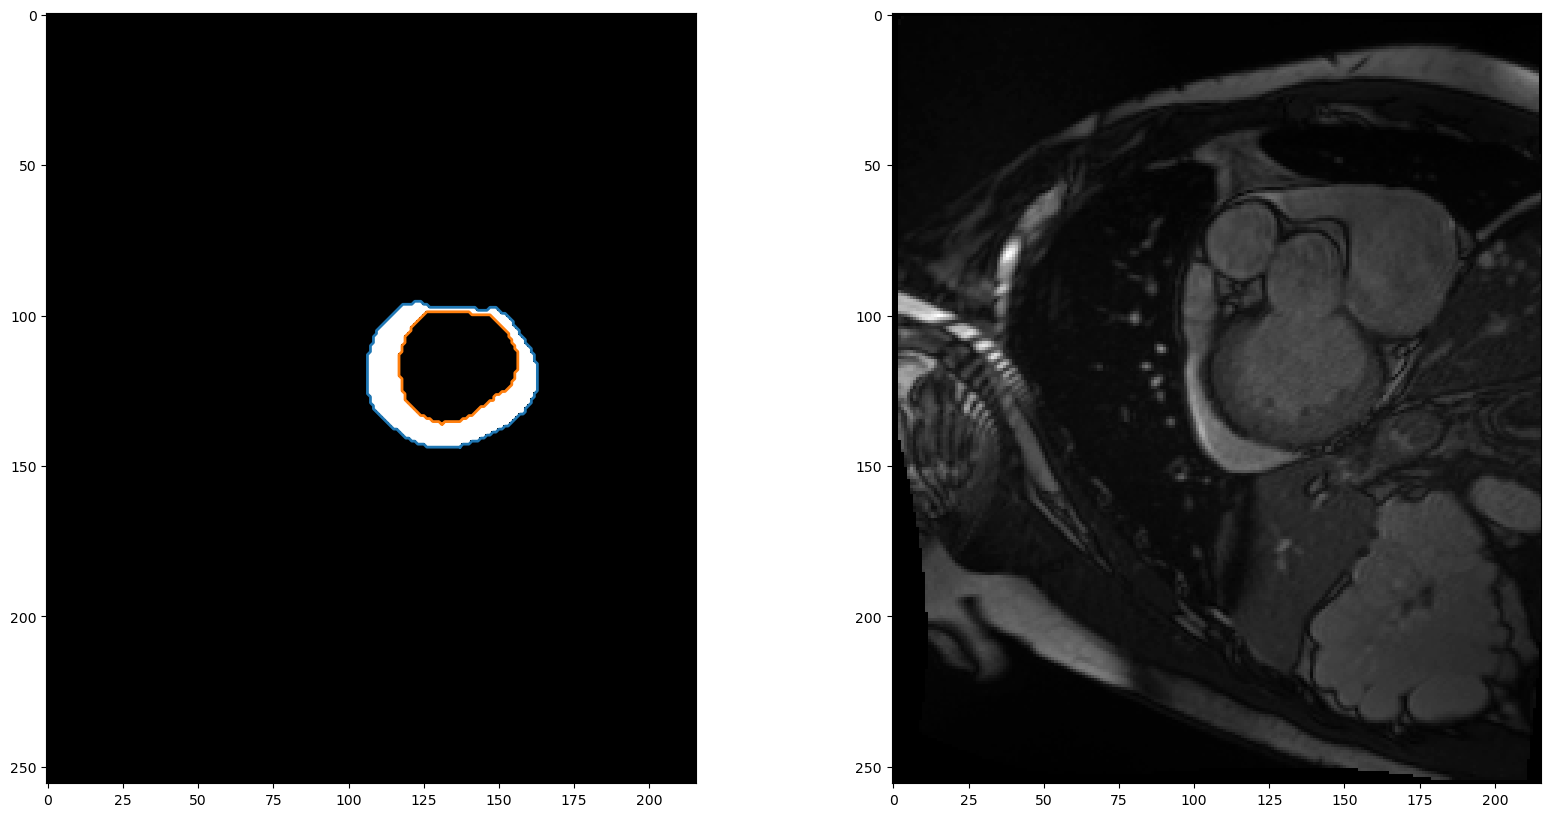

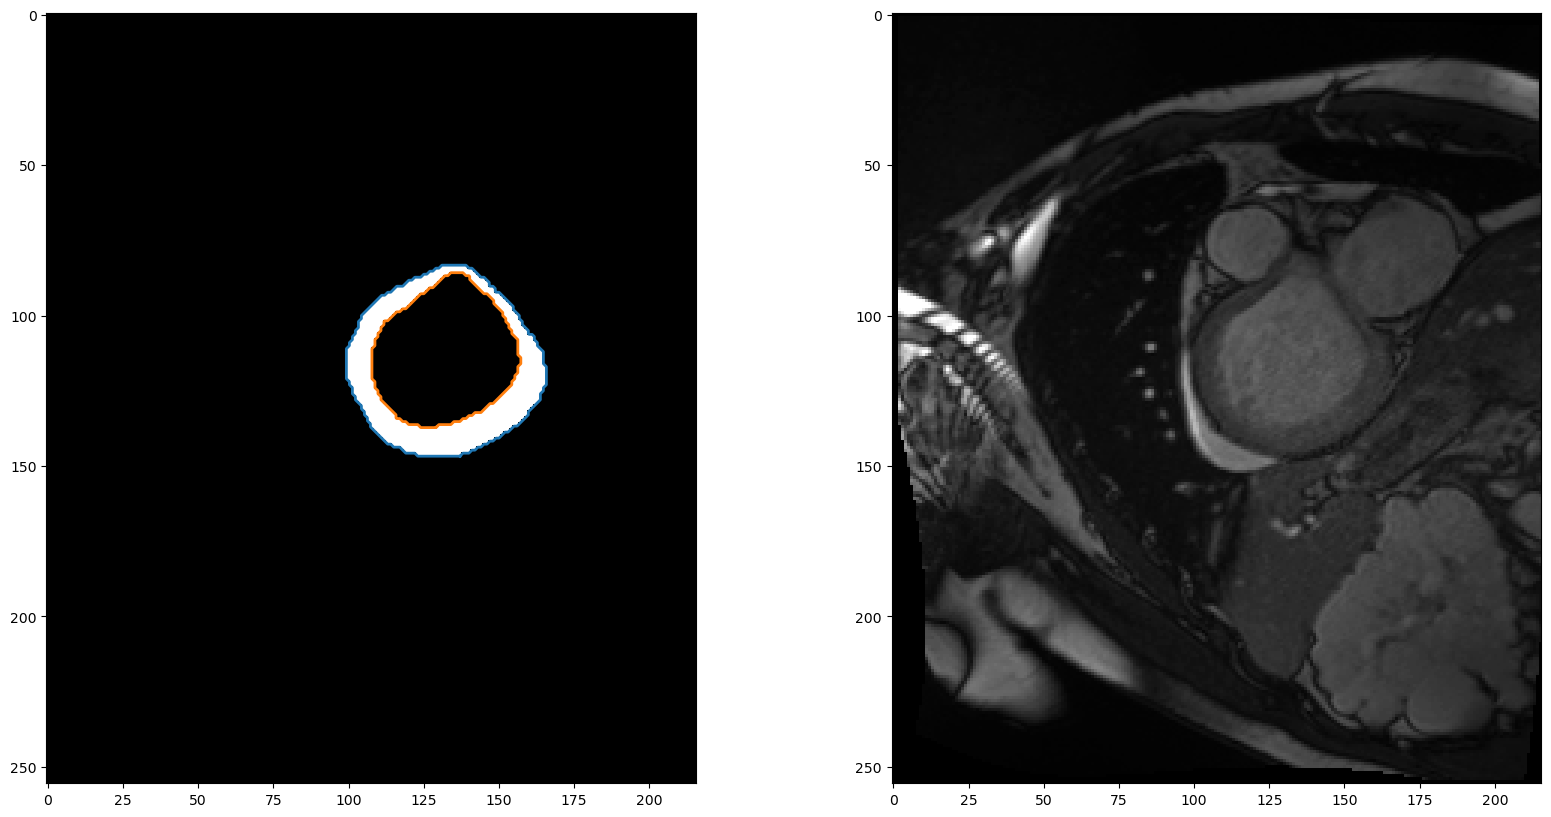

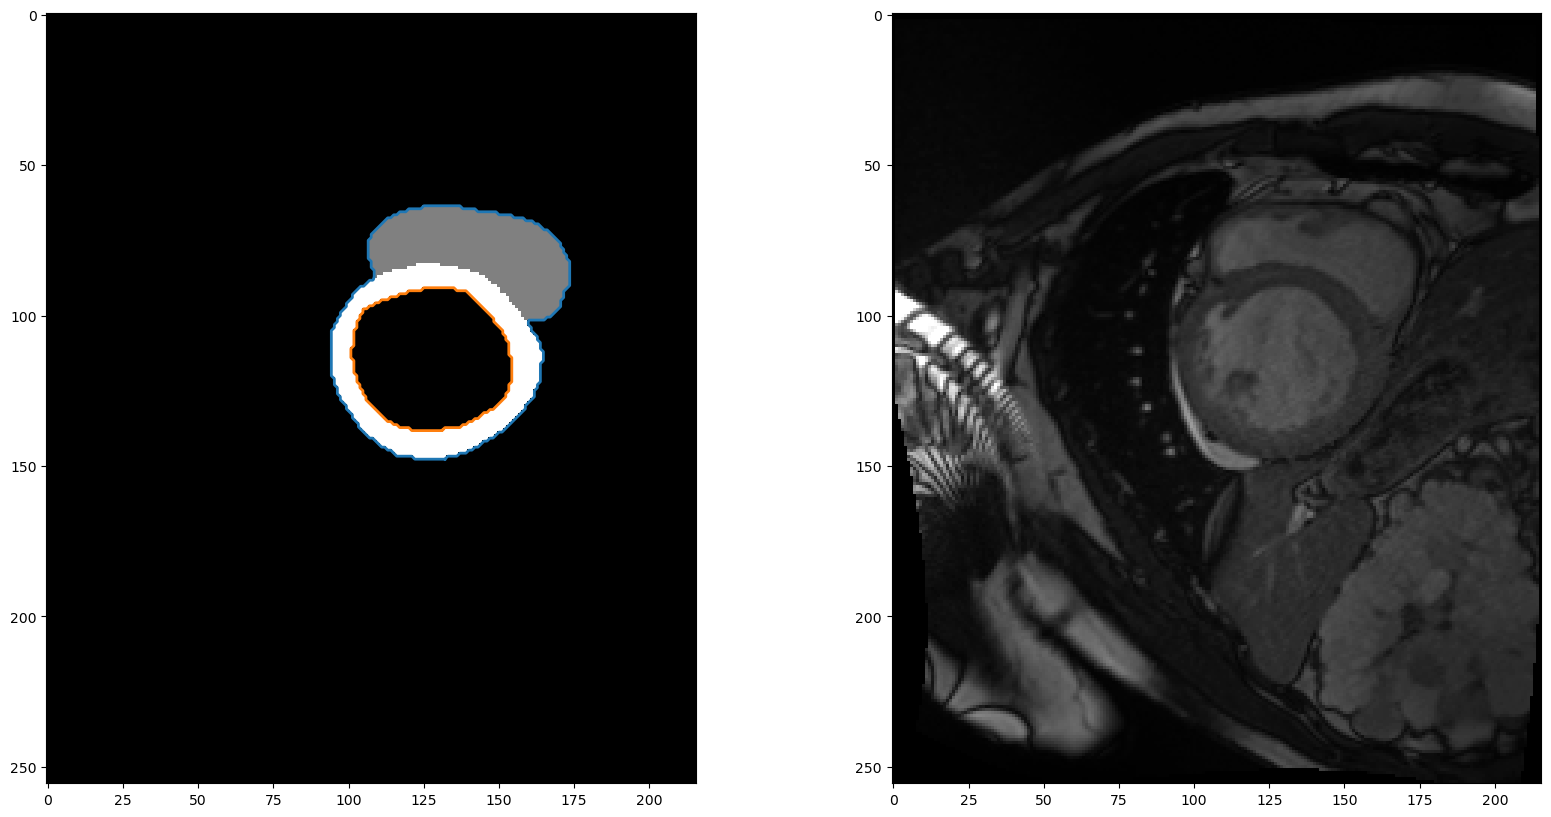

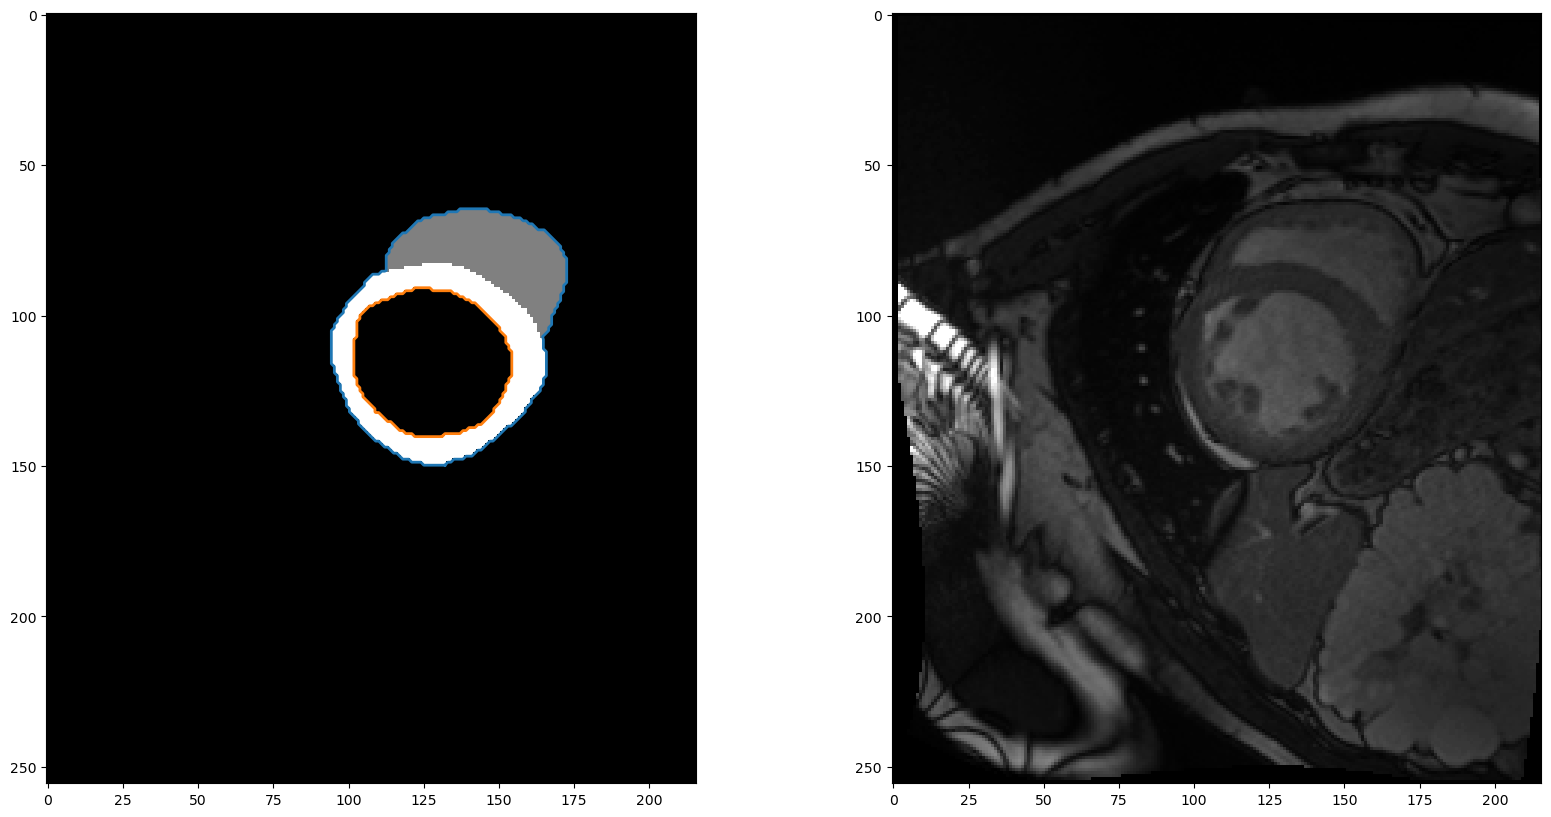

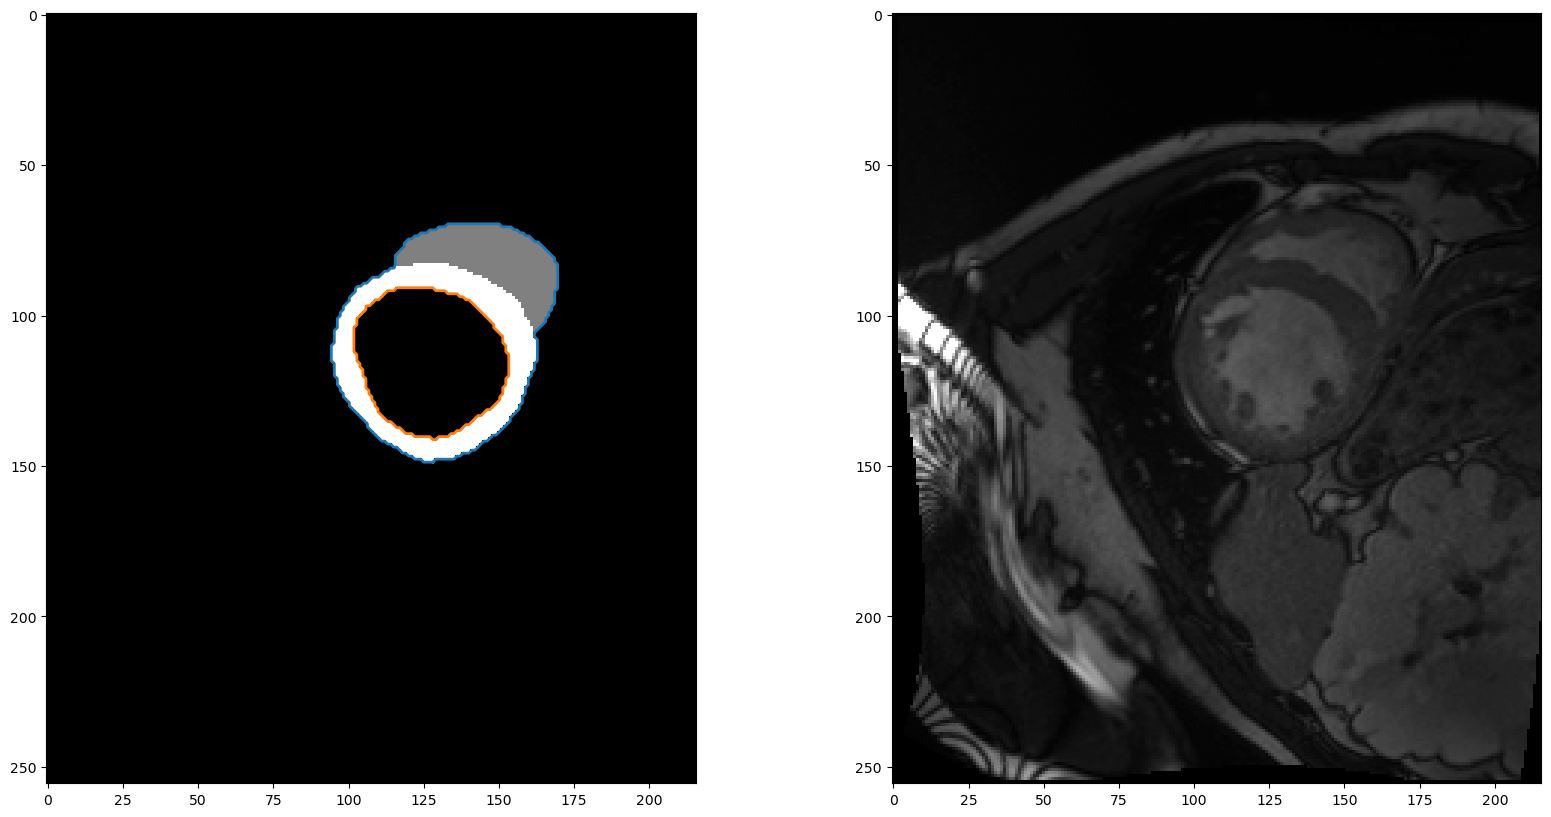

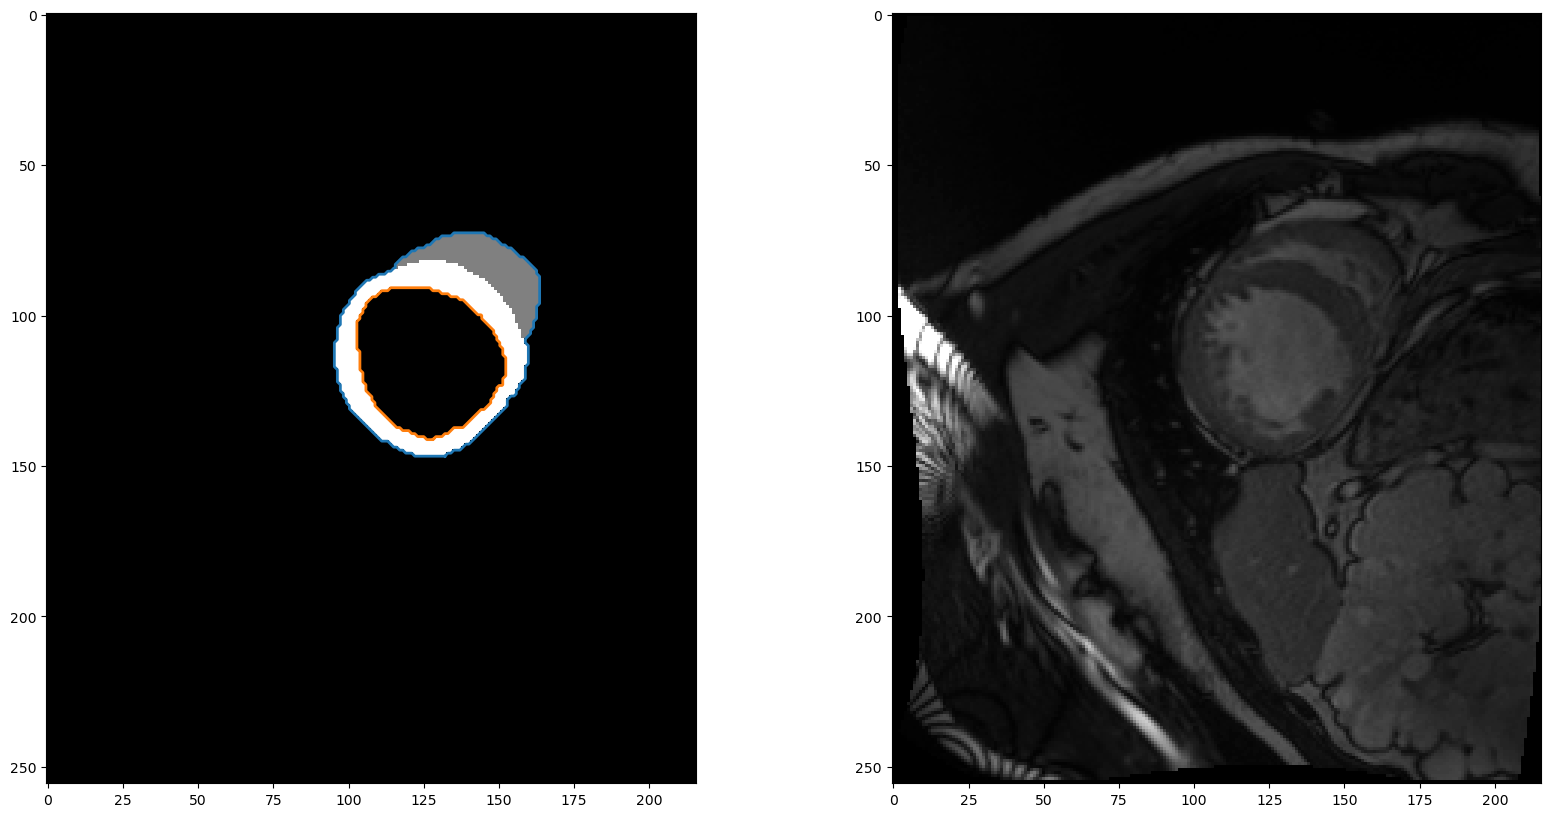

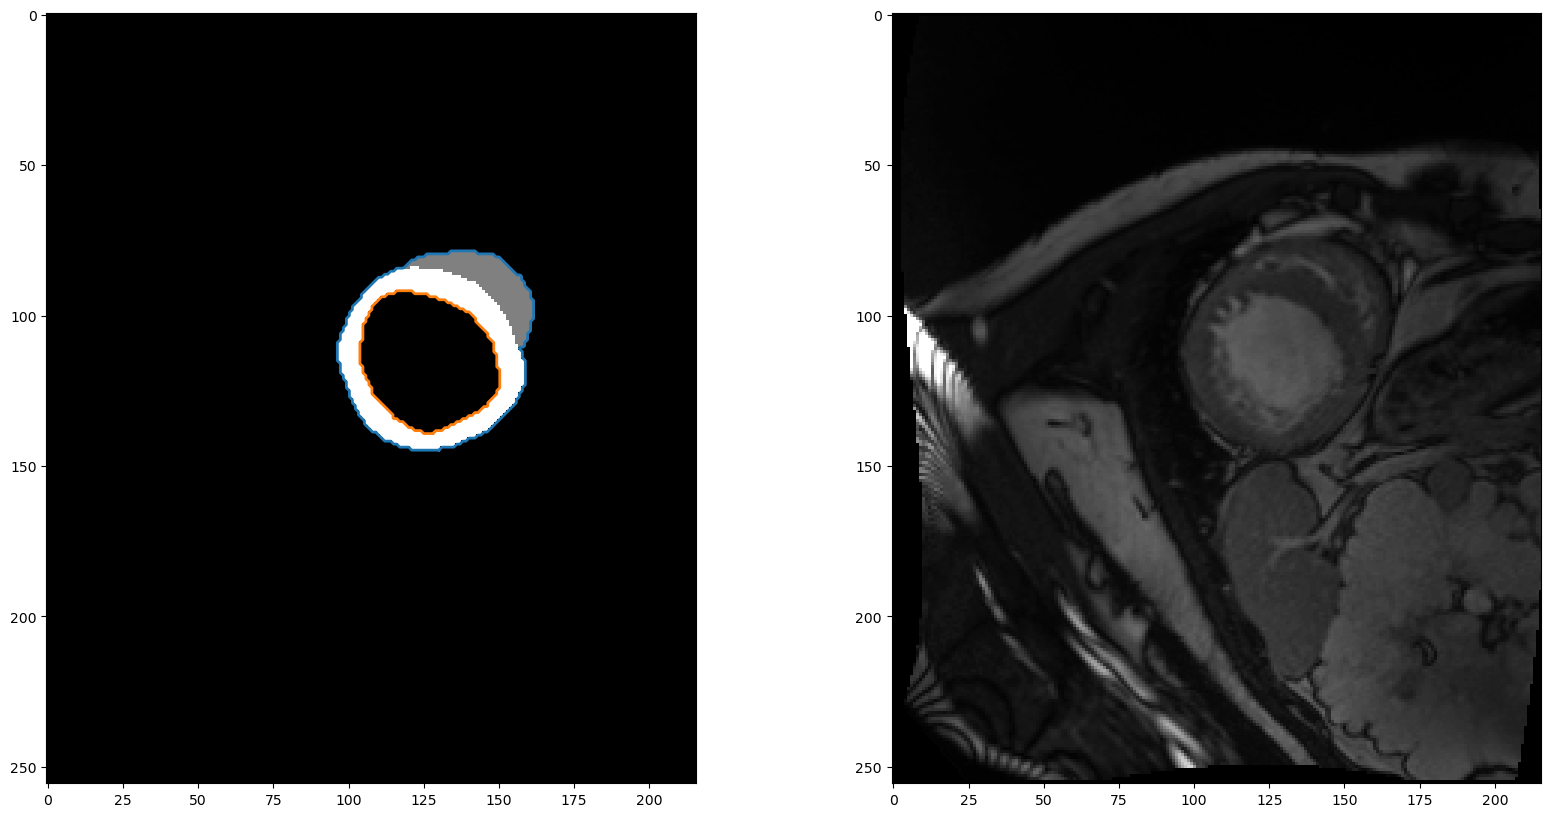

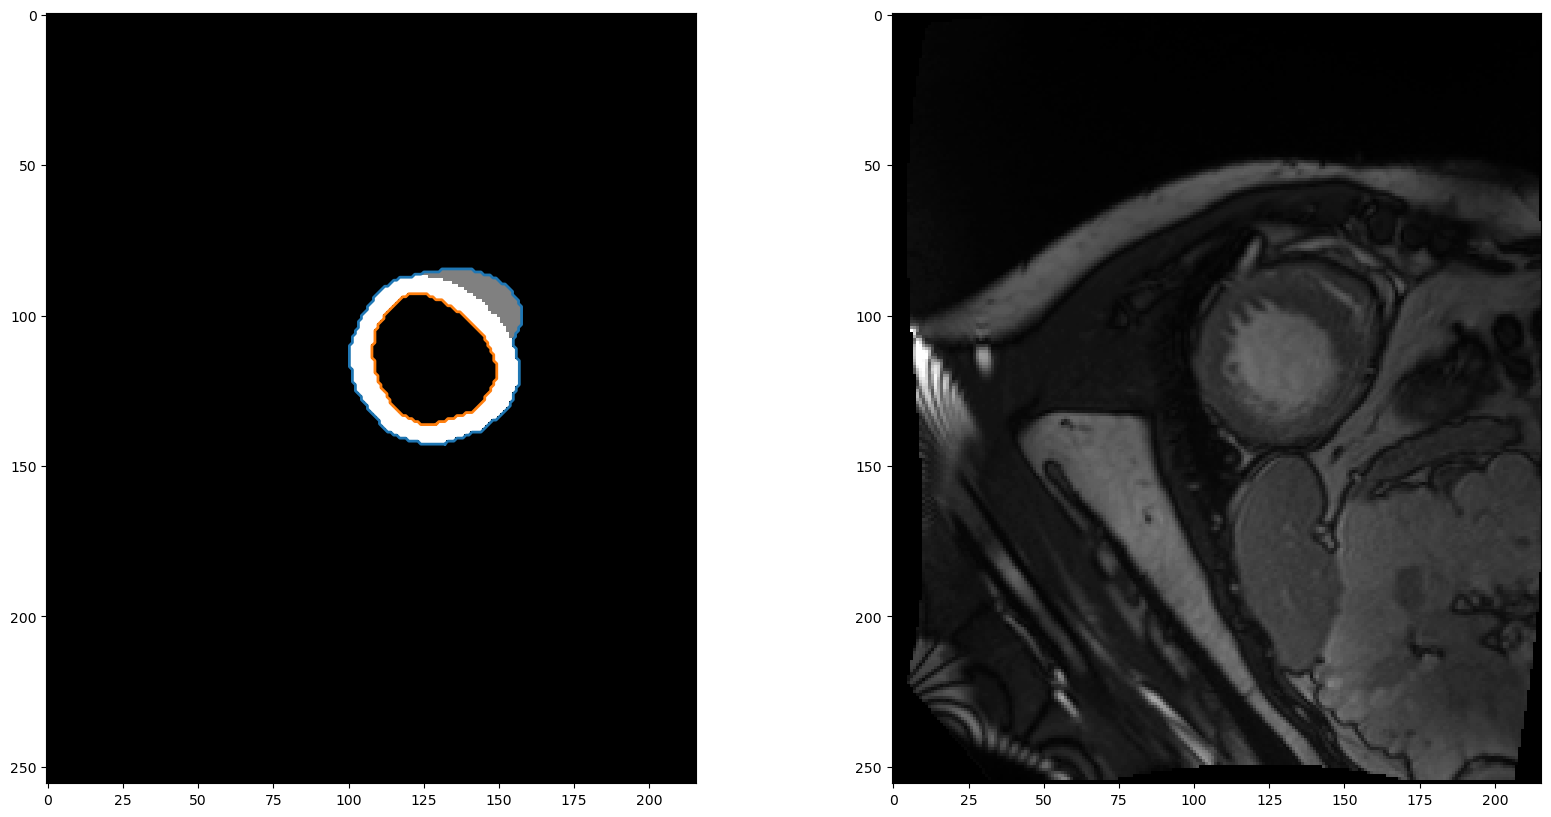

In [ ]:
for i in range(8):
    plt. figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(img_ES_seg[40].get_fdata()[:,:,i], cmap='gray')
    contours = measure.find_contours(img_ES_seg[40].get_fdata()[:,:,i], 0.5)
    # print(img_ES_seg[40].get_fdata()[90:150,100:160,i])
    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.subplot(1,2,2)
    plt.imshow(img_ES[40].get_fdata()[:,:,i], cmap='gray')
    plt.show()
    



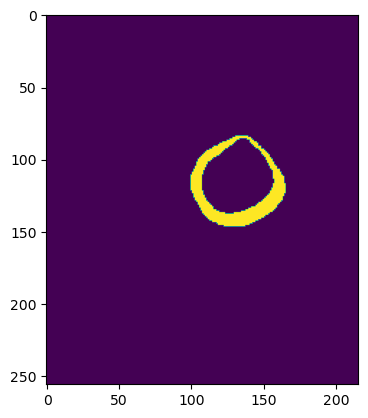

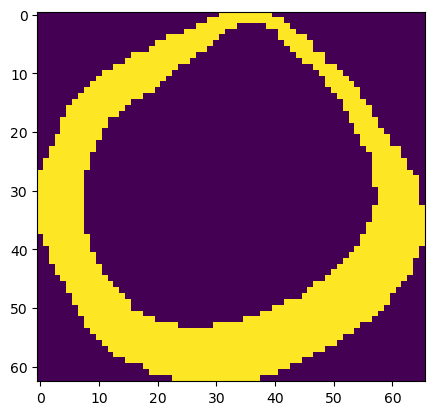

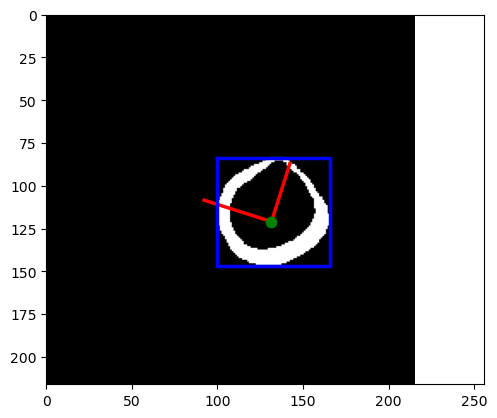

In [ ]:
import math

label_img = measure.label(img_ES_seg[40].get_fdata()[:,:,1].astype(int))
regions = measure.regionprops(label_img)

fig, ax = plt.subplots()
ax.imshow(img_ES_seg[40].get_fdata()[:,:,1], cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, img_ES[40].get_fdata()[:,:,1].shape[0], img_ES[40].get_fdata()[:,:,1].shape[1], 0))
plt.show()

In [ ]:
import skimage
from skimage.segmentation import chan_vese, morphological_chan_vese, checkerboard_level_set,morphological_geodesic_active_contour

r1 = np.sqrt((x0 - x1)**2 + (y0 - y1)**2).astype(int)
r2 = np.sqrt((x0 - x2)**2 + (y0 - y2)**2).astype(int)
r = (r1 + r2)/2

disk = skimage.segmentation.disk_level_set(img_ES_seg[40].get_fdata()[:,:,1].shape, center=[x0,y0], radius=r/2)

In [ ]:
# # plot imgteste and the segmentation image
# plt. figure(figsize=(20,10))
# plt.subplot(1,2,1)
# plt.imshow(imgteste, cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(img_ES_seg[40].get_fdata()[:,:,1], cmap='gray')
# plt.show()
    

    